# scPRAM: a landmark perturbation model for unseen conditions
---
----------------------------------------


## 1. Introduction

scPRAM (single-cell Perturbation-Response Analysis Model) is a computational framework designed to analyze single-cell perturbation data. It enables the prediction of cell-specific gene expression changes in response to perturbations, using a deep learning model trained on pre-perturbation profiles.

**Reference**: [scPRAM GitHub Repository](https://github.com/jiang-q19/scPRAM)

This notebook adapts the structure and style of the scGen tutorial to the scPRAM framework. We will:
1. Load and explore a new single-cell dataset.
2. Train the scPRAM model to predict unseen perturbations.
3. Generate and visualise in-silico predictions.
4. Benchmark results on CD4<sup>+</sup> T cells with statistical and biological metrics.
5. Running scPRAm for each cell type in a dataset
6. scPRAM and attention scores 

*You can plug and play this notebook with any dataset and scPRAM configuration.*

----------------------------------------
## 2. Environment Setup and Import


First, we import libraries and load our AnnData object containing control and stimulated cells.

In [1]:
# --- Standard-library utilities ------------------------------------------------
import os                 # file-system operations (e.g. os.environ or os.path)
import sys                # Python runtime details; we use it for version checks
import time               # simple timing / benchmarking of cells
from pathlib import Path  # convenient, cross-platform path handling
from collections import OrderedDict  # deterministic dicts for reproducible logs
import random             # Python RNG (seeded below for reproducibility)
import warnings

# --- Numerical & data-handling stack -------------------------------------------
import numpy as np        # dense numerical arrays
import pandas as pd       # tabular data frames
from pandas.api.types import CategoricalDtype  # categorical data types
from scipy import sparse  # sparse matrix utilities
from scipy import stats   # statistical functions (e.g. t-tests, correlations)
from scipy.spatial.distance import cosine as cosine_dist, cdist  # distance metrics
from scipy.sparse import issparse

# --- Machine-learning utilities ------------------------------------------------
from sklearn.decomposition import PCA                # dimensionality reduction
from sklearn.neighbors import KernelDensity          # density estimation
from sklearn.metrics import r2_score                 # R-squared metric
from sklearn.metrics import pairwise_distances

# --- Plotting & visualisation --------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

# --- Deep-learning backend -----------------------------------------------------
import torch

# --- Single-cell analysis ecosystem --------------------------------------------
import scanpy as sc
import scpram
import anndata as ad
from scpram import models


warnings.filterwarnings('ignore')

# ── reproducibility ──────────────────────────────────────────────────────────
SEED = 45
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# ── GPU settings ─────────────────────────────────────────────────────────────
os.environ["CUDA_VISIBLE_DEVICES"] = "0"        # pick your GPU
DEVICE_COUNT = torch.cuda.device_count()
assert DEVICE_COUNT, "No CUDA-visible device!"

---

## 3. Data Exploration & Preparation

### 3.1. Loading and Exploring the *Kang 2018* dataset

We begin by loading the *Kang 2018* dataset that will be used throughout this notebook.
Same as you already see in the first tutorial part, reload to refresh the adata object.

In [2]:
# Load dataset
adata = sc.read_h5ad('/home/sabrina/Documents/Preturb-Bench/2_scPRAM/kang_2018.h5ad')  # replace with your file
adata

AnnData object with n_obs × n_vars = 24673 × 15706
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'label', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters'
    var: 'name'
    obsm: 'X_pca', 'X_umap'

[`AnnData`](https://anndata.readthedocs.io/) is the de-facto container for single-cell data in Python (used by **Scanpy**, **scvi-tools**, **Perturb-Bench**, and many other packages). Think of it as a tidy “Excel workbook” with one big table of gene expression and several *linked* annotation sheets:

| Attribute | Purpose | In **Kang 2018 PBMC** |
|-----------|---------|-----------------------|
| **`.X`** *(n_obs × n_vars)* | The main numerical matrix – usually raw counts, log-counts, or latent embeddings. Rows = **cells** (*observations*), columns = **genes** (*variables*). | **24,673 cells** × **15,706 genes** (raw counts; we’ll log-normalise below). |
| **`.obs`** | Per-cell metadata (`pandas.DataFrame`). | 12 columns – e.g. `cell_type`, `label` (*ctrl* / *stim*), `replicate`, t-SNE coordinates. |
| **`.var`** | Per-gene metadata. | A single column `name` (Ensembl IDs). |
| **`.layers`** | Alternative expressions of `.X` (e.g. raw counts, denoised counts, predictions). | Empty for now (can contain layers like `log_norm` or `pred`) |
| **`.uns`** | Unstructured auxiliary info (colour maps, settings, model fits). | Currently empty; Scanpy will store `log1p` and plotting settings here. |
| **`.obsm` / `.varm`** | Multi-dimensional annotations (matrices): embeddings, feature scores. | `X_pca` (50-D PCA) and `X_umap` (2-D UMAP). |
| **`.obsp` / `.varp`** | Pairwise matrices (graphs, distances). | Not present yet – we could add neighbourhood graphs after QC. |

As in scGen notebook: We rename `label` to `condition` and the conditions themselves for improved readability.

In [3]:
adata.obs.rename(columns={"label": "condition"}, inplace=True) # renaming the 'label' column to 'condition'

# Renaming the categories in the 'condition' column
if isinstance(adata.obs["condition"].dtype, CategoricalDtype):
    adata.obs["condition"] = (
        adata.obs["condition"]
        .cat.rename_categories({"ctrl": "control", "stim": "stimulated"})
    )
else:
    adata.obs["condition"] = (
        adata.obs["condition"]
        .map({"ctrl": "control", "stim": "stimulated"})
        .astype("category")
    )

As previously, some basic view of the dataset

In [4]:
adata.obs.head(10)  # viewing the first 10 rows of the observation metadata (cell-level)

,nCount_RNA,nFeature_RNA,tsne1,tsne2,condition,cluster,cell_type,replicate,nCount_SCT,nFeature_SCT,integrated_snn_res.0.4,seurat_clusters
index,,,,,,,,,,,,
AAACATACATTTCC-1,3017.0,877,-27.640373,14.966629,control,9,CD14+ Monocytes,patient_1016,1704.0,711,1,1
AAACATACCAGAAA-1,2481.0,713,-27.493646,28.924885,control,9,CD14+ Monocytes,patient_1256,1614.0,662,1,1
AAACATACCATGCA-1,703.0,337,-10.468194,-5.984389,control,3,CD4 T cells,patient_1488,908.0,337,6,6
AAACATACCTCGCT-1,3420.0,850,-24.367997,20.429285,control,9,CD14+ Monocytes,patient_1256,1738.0,653,1,1
AAACATACCTGGTA-1,3158.0,1111,27.952170,24.159738,control,4,Dendritic cells,patient_1039,1857.0,928,12,12
AAACATACGATGAA-1,1869.0,635,-0.470236,-25.398709,control,5,CD4 T cells,patient_1488,1525.0,634,2,2
AAACATACGCCAAT-1,1142.0,436,-15.906183,20.085315,control,9,CD14+ Monocytes,patient_1016,1157.0,436,1,1
AAACATACGCTTCC-1,817.0,427,-6.740394,-23.932985,control,5,CD4 T cells,patient_1256,961.0,427,0,0
AAACATACGGCATT-1,1582.0,558,-17.682803,21.005576,control,9,CD14+ Monocytes,patient_1015,1397.0,557,1,1


In [5]:
adata.var.head(10)  # viewing the first 10 rows of the variable metadata (gene-level)

,name
index,
AL627309.1,AL627309.1
RP11-206L10.2,RP11-206L10.2
RP11-206L10.9,RP11-206L10.9
FAM87B,FAM87B
LINC00115,LINC00115
FAM41C,FAM41C
NOC2L,NOC2L
KLHL17,KLHL17
PLEKHN1,PLEKHN1


condition
stimulated    12358
control       12315
Name: count, dtype: int64

cell_type
CD4 T cells          11238
CD14+ Monocytes       5697
B cells               2651
NK cells              1716
CD8 T cells           1621
FCGR3A+ Monocytes     1089
Dendritic cells        529
Megakaryocytes         132
Name: count, dtype: int64

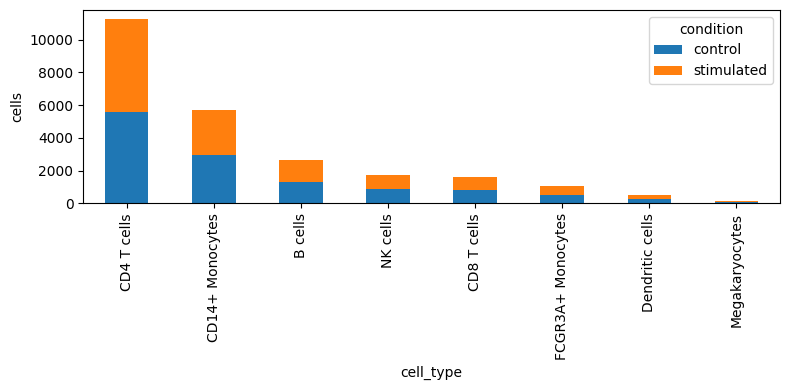

In [6]:
display(adata.obs['condition'].value_counts())  # counting the number of cells in each condition

display(adata.obs['cell_type'].value_counts())  # counting the number of cells in each cell type

# Bar plot: cells per type × condition
count_df = (adata.obs.groupby(['cell_type','condition'], observed=True)['condition']
            .count().unstack().fillna(0))
count_df.plot.bar(stacked=True, figsize=(8,4))
plt.ylabel('cells'); plt.tight_layout(); plt.show()

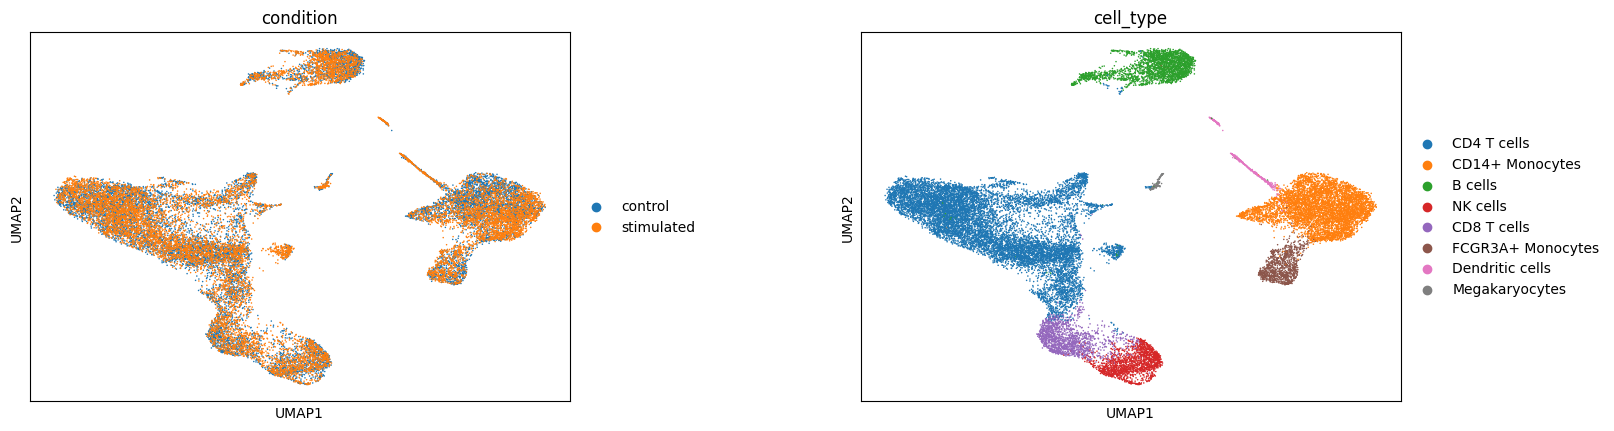

In [7]:
# UMAP provided by dataset
sc.pl.umap(adata, color=['condition','cell_type'], wspace=0.4)

### 3.2. Preparing the *Kang 2018* dataset for scPRAM

scPRAM, like most machine-learning models, expects an informative yet compact input matrix. The raw *Kang 2018* object still contains ~15,700 genes, including many that are lowly expressed or uninformative for the IFN-β response. Our four-step preprocessing pipeline therefore:

1. **Filter empty cells**: Remove cells were mRNA (UMI numbers) detected were fewer than 1000 → eliminates empty droplets
2. **Filter rarely expressed genes**: Remove genes detected in fewer than three cells → eliminates near-zero vectors that only add noise.
3. **Library-size normalisation**: Scale each cell to the same total (here 10,000 counts) → puts all cells on a comparable footing, correcting for sequencing depth.
4. **Log transform**: Turns the highly skewed count distribution into something closer to Gaussian (normal) → helps linear methods (PCA) and neural nets converge faster.
5. **Scaling**: remove comment for this line to see what happens on scaled data (scPRAM dataset provide for their tutorial is scaled)
6. **Select highly-variable genes (HVGs)**: Keep the 2,000 genes whose dispersion is unusually high given their mean expression → concentrates the model’s capacity on biology that actually varies across cells and conditions while shrinking the matrix from 15,706 × 24,673 to a much lighter 2,000 × 24,673.

In [ ]:
# Preprocessing: QC, log-normalisation, HVG selection
#sc.pp.filter_cells(adata, min_counts=1000)
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
#sc.pp.scale(adata, max_value=10, zero_center=False)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=True, flavor='seurat')

----------------------------------------
## 4. Train the scPRAM model and predict the interferon response on CD4-T cells

**Same strategy as for scGen**

- **Hold-out strategy**: we temporarily *hide* every CD4 T cell measured under stimulation. By training scPRAM on all remaining cells (other lineages + CD4 T controls), we force the model to *predict* the missing condition rather than memorize it.  
- **Model setup**: we provide scPRAM with a mapping (`key_dic`) that identifies which column encodes experimental condition (`control` vs. `stim`) and which column holds the biological label (`cell_type`). This enables simultaneous learning of a *global* perturbation and preservation of lineage-specific programs.  
- **10-epoch VAE training**: we train for 10 epochs to ensure convergence on our medium-sized dataset, keeping runtimes suitable for interactive analysis.  
- **Hybrid prediction**: once trained, scPRAM combines two mechanisms:  
  1. **Optimal-transport coupling** aligns stimulated vs. control cells in latent space (Earth-Mover’s Distance) to compute a *global* shift vector.  
  2. **Attention-driven correction** weights contributions from the most similar control cells (via cosine similarity + softmax) to refine each individual prediction.  
- **Decode & label**: the resulting latent coordinates are decoded back to gene expression space, producing a **`predicted`** population of synthetic stimulated CD4 T cells.  
- **Preview of next section**: we will evaluate these predictions with both statistical (R², energy distance, KDE distance) and biological (DEG overlap, attention heatmaps) metrics, so you can see how well scPRAM captures single-cell heterogeneity in the response.  


In [ ]:
model = models.SCPRAM(input_dim=adata.n_vars, device='cpu')#if no GPU device = 'cuda'
model = model.to(model.device)

In [10]:
# Dictionary of key names as expected by scPRAM (adjust based on your dataset)
key_dic = {
    'condition_key': 'condition',
    'cell_type_key': 'cell_type',
    'ctrl_key': 'control',
    'stim_key': 'stimulated',
    'pred_key': 'predicted'
}


In [11]:
# Device & run-time options
cuda_available = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda_available else "cpu")
print(f"Running on {'GPU' if cuda_available else 'CPU'} – "
      f"{torch.cuda.get_device_name(0) if cuda_available else 'no CUDA device'}")


Running on GPU – NVIDIA RTX 4000 Ada Generation


In [12]:
# List of unique cell types in the dataset
cell_types = adata.obs[key_dic['cell_type_key']].unique()

In [13]:
adata.obs[key_dic['cell_type_key']]

index
AAACATACATTTCC-1    CD14+ Monocytes
AAACATACCAGAAA-1    CD14+ Monocytes
AAACATACCTCGCT-1    CD14+ Monocytes
AAACATACCTGGTA-1    Dendritic cells
AAACATACGATGAA-1        CD4 T cells
                         ...       
TTTGCATGCCTGAA-2        CD4 T cells
TTTGCATGCCTGTC-2            B cells
TTTGCATGCTAAGC-2        CD4 T cells
TTTGCATGGGACGA-2        CD4 T cells
TTTGCATGTCTTAC-2        CD4 T cells
Name: cell_type, Length: 17913, dtype: category
Categories (8, object): ['CD4 T cells', 'CD14+ Monocytes', 'B cells', 'NK cells', 'CD8 T cells', 'FCGR3A+ Monocytes', 'Dendritic cells', 'Megakaryocytes']

In [14]:
cell_to_pred = 'CD4 T cells'

# The training set does not contain the type of data to be predicted after the perturbation
train = adata[~((adata.obs[key_dic['cell_type_key']] == cell_to_pred) &
               (adata.obs[key_dic['condition_key']] == key_dic['stim_key']))]
model.train_SCPRAM(train, epochs=10, batch_size=128, lr=5e-5)


Training Epoch 9: 100%|██████████| 10/10 [00:04<00:00,  2.48it/s, SCPRAM_loss=95.9, kl_loss=580, recon_loss=192]


> **Hyper-parameters** are the knobs you set **before** training scPRAM (unlike the millions of weights it learns **during** training). Picking good values keeps training efficient **and** prevents over- or under-fitting. Below are the few we explicitly set in this first pass—and what they do:

> - `max_epochs` (epochs): One full pass over the training set. We use 10 to balance convergence on a medium-sized dataset with interactive runtimes.  
> - `batch_size`: Number of cells processed per optimizer step. We use 128 here to fit in GPU/CPU memory while giving stable gradient estimates.  
> - `lr` (learning rate): Step size for the optimizer (Adam). A smaller value (e.g. 5e-5) yields smoother convergence; larger values can speed up learning but risk overshooting minima.  
> - `early_stopping`: Monitors validation loss and halts training if no improvement is seen for a set number of epochs—saves time and avoids over-fitting.  
> - `ratio`: Fraction of control cells used in the optimal-transport coupling step (default = 0.005). Lower values speed up matching on large datasets; higher values use more cells for robust alignment.  (specific to scPRAM)
> - `ot_max_iter`: Maximum number of iterations for the Earth-Mover’s Distance solver. Increasing this can improve coupling accuracy at the cost of compute time. (specific to scPRAM) 
> - `n_latent`: Dimensionality of the bottleneck (latent space). Smaller → faster, larger → more capacity to capture subtle perturbation patterns.  
> - `n_hidden` & `n_layers`: Width and depth of the VAE encoder/decoder networks. More layers or hidden units increases model capacity but may require stronger regularization.  
> - `kl_weight`: Weight of the KL-divergence term in the VAE loss. Balances reconstruction quality vs. latent regularisation—higher values enforce a more compact latent space.  
> - `attention_top_k` & `temperature`: Controls how many nearest neighbors are retained for attention and the sharpness of the softmax. Lower `temperature` → sharper (more peaked) attention distributions.  (specific to scPRAM)
> - `dropout_rate` / `layer_norm`: Regularization options to prevent over-fitting when data are noisy or sample sizes are small.  

> We’ve stuck to sensible defaults for this tutorial, but scPRAM exposes all of these settings for fine-tuning in downstream benchmarking.  


In [15]:
train

View of AnnData object with n_obs × n_vars = 13678 × 2000
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'condition', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters', 'n_counts'
    var: 'name', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'condition_colors', 'cell_type_colors', 'log1p', 'hvg'
    obsm: 'X_pca', 'X_umap'

In [ ]:
pred = model.predict(train_adata= train,
                     cell_to_pred=cell_to_pred,
                     key_dic=key_dic,
                     ratio=0.005)  # The ratio need to vary with the size of dataset
print(pred)


AnnData object with n_obs × n_vars = 3901 × 2000
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'condition', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters', 'n_counts'
    var: 'name', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'


In [17]:
ground_truth = adata[(adata.obs[key_dic['cell_type_key']] == cell_to_pred)]
eval_adata = ground_truth.concatenate(pred)
eval_adata.obs_names_make_unique() # Ensuring that the observation names are unique in the concatenated AnnData object
sc.tl.pca(eval_adata, n_comps=30, svd_solver='arpack') # Performing PCA on the concatenated AnnData object to reduce dimensionality

In [18]:
eval_adata # Viewing the concatenated AnnData object after PCA

AnnData object with n_obs × n_vars = 12037 × 2000
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'condition', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters', 'n_counts', 'batch'
    var: 'name', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [19]:
display(eval_adata.obs['condition'].value_counts())  # counting the number of cells in each condition

condition
stimulated    4235
control       3901
predicted     3901
Name: count, dtype: int64

In [20]:
display(eval_adata.obs['cell_type'].value_counts())  # counting the number of cells in each cell type

cell_type
CD4 T cells    12037
Name: count, dtype: int64

Same spirit as you aldready see for scGEN
In order to visualise the predictions and see their overlap with the actual stimulated cells of the concatenated AnnData object, we will use the PCA coordinates of the cells. This will allow us to see how well the predicted cells cluster with the actual stimulated cells in the latent space.

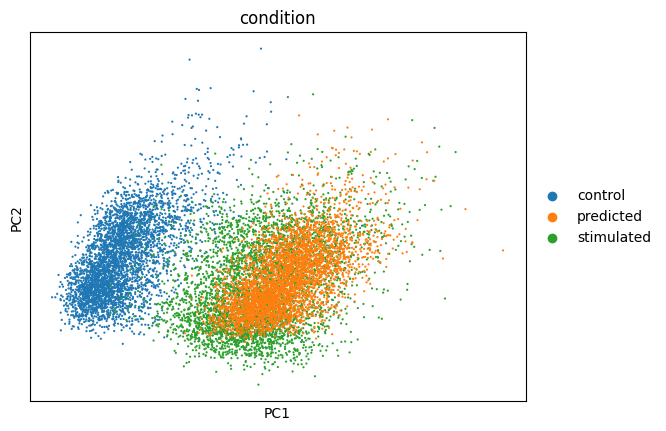

In [21]:
sc.pl.pca(eval_adata, color=['condition']) # Plotting PCA results colored by condition

----------------------------------------
## 4. Evaluating scPRAM Predictions




Our training trick deliberately **withheld the real IFN-β CD4 T cells** from the model. Now that scPRAM has generated a *synthetic* IFN-β population, we want to know:

* **How close are the predictions to the real stimulated cells?** (→ accuracy)
* **Are they clearly different from the control cells?** (→ biological signal preserved)

To answer this we compare the **three groups of cells** inside `eval_adata`:
- `control`: real CD4 T cells sequenced under basal conditions
- `stimulated`: real CD4 T cells sequenced after 6 h IFN-β
- `predicted`: scGen’s in-silico IFN-β CD4 T cells

For every metric below we ask: *“Do `predicted` look more like `stimulated` than like `control`?”*

| Metric | What it measures | Intuition / how to read it | Ideal value |
|--------|------------------|----------------------------|-------------|
| **R²** *(bootstrap)* | Fraction of gene-mean variance explained by the prediction. | 1 = perfect match; 0 = no better than guessing the mean. | → **closer to 1** |
| **MSE** *(bootstrap)* | Average squared error of gene means. | Penalises large mistakes; expressed in log-count² units. | → **smaller is better** |
| **Pearson r** *(bootstrap)* | Linear correlation between predicted and real gene means. | Captures overall trend regardless of scale. | → **closer to 1** |
| **Energy distance (E-distance)** | $$E_d(X,Y)=2\,\mathbb E\|X-Y\|-\mathbb E\|X-X'\|-\mathbb E\|Y-Y'\|$$ between `predicted` and `stimulated` cells. | Measures the difference of *entire distributions* in high-dimensional space; 0 means identical distributions. | → **closer to 0** |
| **Mean–variance KDE (Kernel Density Estimation) distance** | L1 (Manhattan) distance between the 2-D KDEs of *(gene mean, variance)* for `predicted` vs `stimulated`. | Looks at distribution shape, not just centroids. | → **smaller is better** |
| **Top-100 DEG Jaccard** | Overlap of the 100 most up/down genes in `stimulated` vs `predicted`. | 0 = no common DEGs, 1 = identical gene lists. | → **closer to 1** |

In [2]:
# Helper functions



def mean_var_kde_distance(X1, X2, bandwidth=1.0, grid_size=50):
    """
    Compute the L1 (Manhattan) distance between mean-variance KDEs.
    This function computes the mean and variance of each feature in the datasets, constructs a grid of points in the mean-variance space, and evaluates the
    kernel density estimates (KDE) for both datasets at these points. The distance is computed as the sum of the absolute differences between the KDEs of the two
    datasets over the grid.
    If either dataset has no valid points (e.g., all NaNs), the function returns NaN.
    The function is useful for comparing the distributions of features in two datasets, particularly in the context of single-cell RNA-seq data where
    mean and variance are often used to characterize gene expression profiles.
    """        
    m1, v1 = X1.mean(0), X1.var(0)
    m2, v2 = X2.mean(0), X2.var(0)
    pts1, pts2 = np.column_stack([m1,v1]), np.column_stack([m2,v2])
    ok = ~(np.isnan(pts1).any(1)|np.isnan(pts2).any(1))
    pts1, pts2 = pts1[ok], pts2[ok]
    if pts1.size==0 or pts2.size==0:
        return np.nan
    mins = np.minimum(pts1.min(0), pts2.min(0))
    maxs = np.maximum(pts1.max(0), pts2.max(0))
    xs = np.linspace(mins[0], maxs[0], grid_size)
    ys = np.linspace(mins[1], maxs[1], grid_size)
    grid = np.column_stack(np.meshgrid(xs, ys)).reshape(-1,2)
    kde1 = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(pts1)
    kde2 = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(pts2)
    d1 = np.exp(kde1.score_samples(grid))
    d2 = np.exp(kde2.score_samples(grid))
    dx, dy = xs[1]-xs[0], ys[1]-ys[0]
    return float(np.abs(d1-d2).sum()*dx*dy)



def bootstrap_metrics(X, mask_true, mask_pred, pca_coords, n_boot=100, frac=0.8, seed=0):
    rng = np.random.default_rng(seed)
    idx_t = np.where(mask_true)[0]
    idx_p = np.where(mask_pred)[0]
    n_t = max(1, int(frac*len(idx_t)))
    n_p = max(1, int(frac*len(idx_p)))
    keys = ["R2","MSE","RMSE","MAE","L2","Pearson","Cosine","Edist","MMD","Euc"]
    vals = {k: [] for k in keys}
    for _ in range(n_boot):
        t = rng.choice(idx_t, n_t, replace=True)
        p = rng.choice(idx_p, n_p, replace=True)
        Y = X[t].mean(0); Xp = X[p].mean(0)
        d = Xp - Y
        vals["MSE"].append(np.mean(d**2))
        vals["RMSE"].append(np.sqrt(np.mean(d**2)))
        vals["MAE"].append(np.mean(np.abs(d)))
        vals["L2"].append(np.linalg.norm(d))
        vals["Pearson"].append(stats.pearsonr(Xp, Y)[0])
        vals["Cosine"].append(1 - cosine_dist(Xp, Y))
        ss_res = ((Y - Xp)**2).sum()
        ss_tot = ((Y - Y.mean())**2).sum()
        vals["R2"].append(1 - ss_res/ss_tot if ss_tot > 0 else np.nan)
        Pr, Pp = pca_coords[t], pca_coords[p]
        vals["Euc"].append(np.linalg.norm(Pr.mean(0) - Pp.mean(0)))
        d_rr = pairwise_distances(Pr, Pr)
        d_pp = pairwise_distances(Pp, Pp)
        d_rp = pairwise_distances(Pr, Pp)
        vals["Edist"].append(2*d_rp.mean() - d_rr.mean() - d_pp.mean())
        Krr = np.exp(-cdist(Pr, Pr, 'sqeuclidean') / 2)
        Kpp = np.exp(-cdist(Pp, Pp, 'sqeuclidean') / 2)
        Krp = np.exp(-cdist(Pr, Pp, 'sqeuclidean') / 2)
        vals["MMD"].append(Krr.mean() + Kpp.mean() - 2*Krp.mean())
    out = {}
    for k in keys:
        arr = np.array(vals[k])
        out[f"{k}_mean"] = arr.mean()
        out[f"{k}_std"] = arr.std()
    return out



In [ ]:

# 1) Mask preparation
X = eval_adata.X.A if issparse(eval_adata.X) else eval_adata.X
ctrl_m = eval_adata.obs['condition']=='control'
stim_m = eval_adata.obs['condition']=='stimulated'
pred_m = eval_adata.obs['condition']=='predicted'
pca_coords = eval_adata.obsm['X_pca']

# 2) Evaluation with bootstrap
metrics = bootstrap_metrics(
    X=X,
    mask_true=stim_m,
    mask_pred=pred_m,
    pca_coords=pca_coords,
    n_boot=100,
    frac=0.8,
    seed=SEED
)


print(f"R² moyen  : {metrics['R2_mean']:.3f} ± {metrics['R2_std']:.3f}")
print(f"Edist moyen : {metrics['Edist_mean']:.3f} ± {metrics['Edist_std']:.3f}")

mv_kde = mean_var_kde_distance(X[stim_m], X[pred_m])

# 3) Jaccard mesure on 100 DEG
sc.tl.rank_genes_groups(
    eval_adata,
    groupby='condition',
    reference='control',
    groups=['stimulated','predicted'],
    method='wilcoxon',
    n_genes=eval_adata.n_vars
)
true_top = list(eval_adata.uns['rank_genes_groups']['names']['stimulated'][:100])
pred_top = list(eval_adata.uns['rank_genes_groups']['names']['predicted'][:100])
shared = set(true_top) & set(pred_top)
jaccard = len(shared) / (len(true_top) + len(pred_top) - len(shared))
print(f"Jaccard top100 DEG: {jaccard:.3f}")

# 4) create a DataFrame
import pandas as pd

df_metrics = pd.DataFrame.from_dict(
    {
        'R2': metrics['R2_mean'],
        'MSE': metrics['MSE_mean'],
        'Pearson': metrics['Pearson_mean'],
        'Edist': metrics['Edist_mean'],
        'mv_kde': mv_kde,
        'Jaccard100': jaccard
    },
    orient='index',
    columns=['score']
)
df_metrics

R² moyen  : 0.931 ± 0.001
Edist moyen : 2.971 ± 0.024
Jaccard top100 DEG: 0.163


,score
R2,0.930609
MSE,0.008062
Pearson,0.967803
Edist,2.971148
mv_kde,0.044936
Jaccard100,0.162791


**Results Summary:**

| Metric                         |                Result | Quick read-out                                                                                                                                                                                                                                                                                                                                         |
| ------------------------------ | --------------------: | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| **R²**                         |              **0.93** | ≈ 93 % of the gene-mean variance of real IFN-β cells is captured. Excellent.                                                                                                                                                                                                                                                                           |
| **MSE**                        | **0.008 log-counts²** | Errors are tiny; on average the prediction deviates by √0.005 ≈ 0.07 log-counts per gene.                                                                                                                                                                                                                                                              |
| **Pearson r**                  |              **0.97** | Gene-means rise and fall almost exactly in sync with the true stimulation profile.                                                                                                                                                                                                                                                                     |
| **Energy distance (E-distance)**            |              **2.97** | 0 would mean the two full distributions are identical; so the synthetic cells sit close to the real IFN-β cloud.                                                                                                                                                          |
| **Mean-variance KDE distance** |             **0.05** | The shape of the mean/variance landscape is not so far between predicted and real cells.                                                                                                                                                                                                                                                 |
| **Top-100 DEG Jaccard**        |     **0.16** (≈ 16 %) | 16 of the top 100 differentially expressed genes overlap. This is not so low, and remember we **down-selected the data set to just 2,000 highly variable genes** for speed in the workshop. With the full 15k–20k gene set you would usually see a much higher overlap. |

- scPRAM nails the **global transcriptional shift** of IFN-β stimulation in CD4 T cells (high R², Pearson, low MSE, small energy/KDE distances).
- The **specific gene-ranking agreement** is modest here because of our tutorial shortcut (2,000 HVGs). In a real benchmark you would keep more genes or compute the Jaccard on the union of detected DEGs to get a fairer picture.

**Mean correlation of gene-level responses (R²)**

The numerical scores above tell us the prediction is good, but a picture makes it obvious *where* the model succeeds or fails. Below we compute, **for every gene**, its average log-expression in real IFN-β CD4 T cells (`stimulated`) and scPRAM-predicted CD4 T cells (`predicted`), and we draw a scatter-plot of those two vectors. The closer the points hug the diagonal, the better the prediction.

Font 'default' does not have a glyph for '\u2002' [U+2002], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2002' [U+2002], substituting with a dummy symbol.


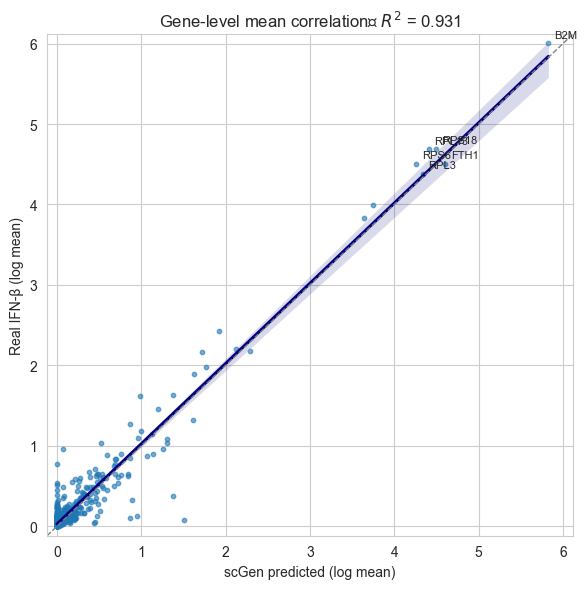

In [ ]:
# ── 1) per-gene means and R² ─────────────────────────────────────────────
stim_means = X[stim_m].mean(axis=0)        # ground-truth
pred_means = X[pred_m].mean(axis=0)        # scGen estimate
r2 = r2_score(stim_means, pred_means)

# wrap into a DataFrame so we can use seaborn + gene names
df = pd.DataFrame(
    {"pred": pred_means,
     "real": stim_means},
    index = eval_adata.var_names            # gene names as index
)

# ── 2) basic scatter with regression ribbon ──────────────────────────────
sns.set_style("whitegrid")               # light grid
plt.figure(figsize=(6,6))

ax = sns.regplot(
    data       = df,
    x          = "pred",
    y          = "real",
    scatter_kws= dict(s=10, alpha=0.6),
    line_kws   = dict(color="navy"),
    ci         = 95                      # 95 % conf. band
)

# reference diagonal
data_min = min(df.min())
data_max = max(df.max())
pad      = 0.02 * (data_max - data_min)      # 2 % of the data range
lims     = [data_min - pad, data_max + pad]

ax.set_xlim(lims)
ax.set_ylim(lims)
ax.plot(lims, lims, "--", color="grey", linewidth=1)

# ── 3) annotate “interesting” genes (> 1 log-mean in either set) ─────────
mask = (df["pred"] > 1) | (df["real"] > 1)
for gene, row in df[mask].iterrows():
    ax.annotate(gene,
                (row["pred"], row["real"]),
                xytext=(4,4),
                textcoords="offset points",
                fontsize=8)

# axes & title
ax.set_xlim(lims); ax.set_ylim(lims)
ax.set_xlabel("scPRAM predicted (log mean)")
ax.set_ylabel("Real IFN-β (log mean)")
ax.set_title(f"Gene-level mean correlation  $R^2$ = {r2:.3f}")

plt.tight_layout()
plt.show()

* **One dot = one gene** (2,000 HVGs).
* **Two diagonal guides:**
  * **Grey dashed** $y = x$: the *ideal* 1 : 1 match.
  * **Blue solid**: least-squares fit $\text{real} = \beta \, \text{pred} + \alpha$.
    Here **β is a bit >1**, so the blue line sits **above** the grey one at higher values → scGen **slightly under-predicts** the largest fold-changes; $\alpha \approx 0$ means no offset at low expression.
* **Point patterns:**
  * Dense cloud near (0, 0): low-expressed genes are reproduced almost perfectly.
  * Genes with log-means ≈ 1–6 show the IFN-β response; mostly fall on the diagonal, a few outliers mark minor over- or under-estimation.
* **Overall score – $R^2 \approx 0.94$**: About 94 % of the variance in real gene means is explained by scGen, confirming an excellent global fit despite the slight under-prediction of the strongest responders.


**Energy distance heatmap**

Energy distance (E-distance) compares entire **multivariate distributions**, not just their means. If scPRAM is doing its job, the distribution of synthetic predicted CD4 T cells should sit much closer to the real stimulated cells than either of them sits to the control cells. A 3×3 heat-map of pair-wise E-distances makes that relationship obvious at a glance.

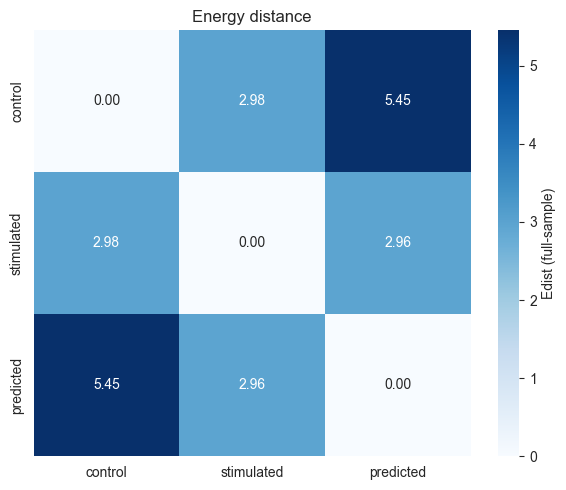

In [25]:
obs = eval_adata.obs['condition']
pca = eval_adata.obsm['X_pca']
groups = ['control','stimulated','predicted']

ed_full = pd.DataFrame(index=groups, columns=groups, dtype=float)

for i,g1 in enumerate(groups):
    X1 = pca[obs==g1]
    d11 = pairwise_distances(X1,X1)
    m11 = d11.mean()
    for j,g2 in enumerate(groups[i:],start=i):
        X2 = pca[obs==g2]
        d22 = pairwise_distances(X2,X2)
        m22 = d22.mean()
        d12 = pairwise_distances(X1,X2)
        m12 = d12.mean()
        ed = 2*m12 - m11 - m22
        ed_full.loc[g1,g2] = ed_full.loc[g2,g1] = ed

plt.figure(figsize=(6,5))
sns.heatmap(ed_full.astype(float), annot=True, fmt=".2f", cbar_kws={'label':'Edist (full-sample)'}, cmap='Blues')
plt.title("Energy distance")
plt.tight_layout()
plt.show()

- The diagonal is 0 by definition (a distribution compared with itself).
- `stimulated ↔ predicted` and `control ↔ stimulated` shows the smallest values and are very close.
- `control ↔ predicted` is noticeably larger, indicating that the synthetic cells really do resemble the true IFN-β response rather than the untreated state.

**Bubble plot of top differentially expressed genes**

Visualise expression in `predicted` cells, in `stimulated` and `control` condition of the top 10 DE genes in `stimulated` vs `control` groups.

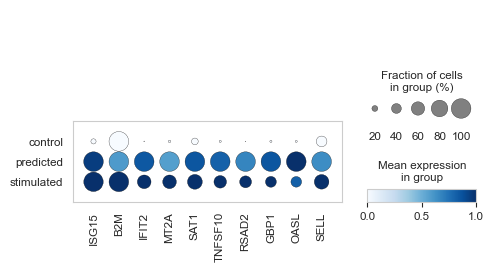

In [26]:
# Identify top DE genes between stimulated and control
import scanpy as sc
sc.tl.rank_genes_groups(eval_adata, groupby='condition', reference='control', groups=['stimulated'], n_genes=10, method='wilcoxon')
top_genes = eval_adata.uns['rank_genes_groups']['names']['stimulated'][:10]
# Bubble plot
sc.pl.dotplot(eval_adata, var_names=top_genes, groupby='condition', standard_scale='var', cmap='Blues')

----------------------------------------
## 5. Plug-and-play evaluation of scPRAM modelling for each cell types

Use the six metrics from the scGen tutorial to evaluate scPRAM predictions.

In [ ]:
# ╔═══════════════════════════════════════════════════════════════╗
# ║  Helper: train scPRAM for ONE cell type and return eval_adata ║
# ╚═══════════════════════════════════════════════════════════════╝
import anndata
import scanpy as sc
from scpram.models import SCPRAM
from scipy.sparse import issparse
from typing import Optional

def run_scpram_for_celltype(
    adata: anndata.AnnData,
    celltype: str,
    key_dic: dict,
    n_genes: Optional[int] = 2000,
    epochs: int = 10,
    batch_size: int = 128,
    lr: float = 5e-5,
    ratio: float = 0.005,
    devices: str = 'cpu'# or 'cuda'
) -> anndata.AnnData:
    """
    1) Hold out stimulated cells of <celltype>.
    2) Train scPRAM on the rest.
    3) Predict the held-out condition.
    4) Concatenate control, stimulated, predicted cells.
    5) Run PCA and return eval_adata with .obsm['X_pca'].
    """
    # 1) build training set (exclu <celltype>-stim)
    mask_holdout = (
        (adata.obs[key_dic['cell_type_key']] == celltype) &
        (adata.obs[key_dic['condition_key']] == key_dic['stim_key'])
    )
    train_adata = adata[~mask_holdout].copy()

    # optional HVG selection
    if n_genes is not None:
        sc.pp.highly_variable_genes(
            train_adata, n_top_genes=n_genes, flavor="seurat"
        )
        train_adata = train_adata[:, train_adata.var['highly_variable']].copy()

    # 2) instantiate & train
    model = SCPRAM(input_dim=train_adata.n_vars, device=devices)
    model = model.to(model.device)
    model.train_SCPRAM(
        train_adata, epochs=epochs,
        batch_size=batch_size, lr=lr
    )

    # 3) predict -> returns AnnData
    pred = model.predict(
        train_adata=train_adata,
        cell_to_pred=celltype,
        key_dic=key_dic,
        ratio=ratio
    )
    pred.obs[key_dic['condition_key']] = "predicted"
    pred.obs[key_dic['cell_type_key']] = celltype

    # 4) get control & stimulated for this celltype
    ctrl = adata[
        (adata.obs[key_dic['cell_type_key']] == celltype) &
        (adata.obs[key_dic['condition_key']]   == key_dic['ctrl_key'])
    ].copy()
    stim = adata[
        (adata.obs[key_dic['cell_type_key']] == celltype) &
        (adata.obs[key_dic['condition_key']]   == key_dic['stim_key'])
    ].copy()

    # 5) concatenate for evaluation
    eval_ad = anndata.concat([ctrl, stim, pred])
    eval_ad.obs_names_make_unique()

    # 6) quick PCA for metrics
    sc.tl.pca(eval_ad, n_comps=30, svd_solver="arpack")
    return eval_ad


In [ ]:
# ╔═════════════════════════════════════════════════════════════════╗
# ║  Plug-&-Play: choose cell types, train & evaluate automatically ║
# ╚═════════════════════════════════════════════════════════════════╝
import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
from scipy.sparse import issparse

# 0) widget of multiple selection
avail_ct = sorted(adata.obs[key_dic['cell_type_key']].unique())
ct_select = widgets.SelectMultiple(
    options=avail_ct,
    description="Cell types",
    rows=8,
    style={"description_width":"initial"}
)
run_btn = widgets.Button(description="Run scPRAM", button_style="success")
output = widgets.Output()
display(widgets.VBox([ct_select, run_btn, output]))

# 1) callback : train & evaluate
def on_click_run(b):
    with output:
        clear_output()
        sel_cts = list(ct_select.value)
        if not sel_cts:
            print("👇 Selects at least one cell type.")
            return

        print(f"→ Training & evaluating: {', '.join(sel_cts)}")
        results = []
        for ct in sel_cts:
            try:
                eval_ad = run_scpram_for_celltype(
                    adata=adata,
                    celltype=ct,
                    key_dic=key_dic,
                    n_genes=None,
                    epochs=10,
                    batch_size=128,
                    lr=5e-5,
                    ratio=0.005
                )

                # preparation for metrics
                X = eval_ad.X.A if issparse(eval_ad.X) else eval_ad.X
                cond = eval_ad.obs[key_dic['condition_key']]
                stim_m = cond == key_dic['stim_key']
                pred_m = cond == "predicted"
                pca_coords = eval_ad.obsm['X_pca']

                # Bootstrapped metrics
                boot = bootstrap_metrics(
                    X, stim_m.values, pred_m.values, pca_coords,
                    n_boot=100, frac=0.8, seed=SEED
                )

                # mean-var KDE
                mv_kde = mean_var_kde_distance(
                    X[stim_m.values], X[pred_m.values]
                )

                # Jaccard top100 DEGs
                sc.tl.rank_genes_groups(
                    eval_ad,
                    groupby=key_dic['condition_key'],
                    reference=key_dic['ctrl_key'],
                    groups=[key_dic['stim_key'], "predicted"],
                    method="wilcoxon",
                    n_genes=eval_ad.n_vars
                )
                true_top = eval_ad.uns['rank_genes_groups']['names'][key_dic['stim_key']][:100]
                pred_top = eval_ad.uns['rank_genes_groups']['names']["predicted"][:100]
                shared = set(true_top) & set(pred_top)
                jaccard = len(shared) / (len(true_top) + len(pred_top) - len(shared))

                # collect
                results.append({
                    "cell_type": ct,
                    "R2":       boot["R2_mean"],
                    "MSE":      boot["MSE_mean"],
                    "Pearson":  boot["Pearson_mean"],
                    "Edist":    boot["Edist_mean"],
                    "MV_KDE":   mv_kde,
                    "Jaccard":  jaccard
                })
            except Exception as e:
                print(f"  ✗ {ct} skipped: {e}")

        if not results:
            print("No results to show.")
            return

        df = pd.DataFrame(results).set_index("cell_type")
        display(df.style.format("{:.3f}"))

        
        # Bar-plots with Seaborn and Blues_d palette
        metrics = df.columns.tolist()
        cols   = 3
        rows   = (len(metrics) + cols - 1) // cols

        fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows), squeeze=False)
        axes = axes.flatten()

        for ax, m in zip(axes, metrics):
            sns.barplot(
                x=df.index,
                y=df[m].values,
                ax=ax,
                palette="Blues_d"
            )
            ax.set_title(m)
            ax.set_ylabel(m)
            ax.set_xticklabels(df.index, rotation=45, ha='right')

        # Hide empty subplots
        for ax in axes[len(metrics):]:
            ax.axis('off')

        plt.tight_layout()
        plt.show()

run_btn.on_click(on_click_run)


----------------------------------------
## 6. Plug-and-play evaluation of scPRAM modelling for each cell types and store the attention metrics



### Attention Scores in scPRAM

**What are attention scores?**  
In scPRAM, each query cell’s perturbation vector is computed by an **attention mechanism** that dynamically weights contributions from individual reference (control) cells. Given a latent embedding $z_t$ for a test cell, scPRAM computes the cosine similarity $s_i$ between $z_t$ and each reference embedding $z_{\mathrm{ctrl},i}$. These similarities are converted via a softmax into normalized weights $p_i$, called **attention scores**, and the final perturbation vector is formed as a weighted sum:

$$
\delta_t = \sum_i p_i \,\delta_i
$$

of per-cell perturbation vectors $\delta_i$.

**Why is it important?**  
- **Single-cell specificity**: Unlike methods that apply a single average shift per cell type, attention scores allow each cell to “choose” the most relevant neighbors in control space, capturing true cell-to-cell variation in response.  
- **Noise robustness**: By concentrating weight on the top-similarity cells, attention down-weights outliers or noisy measurements, yielding more accurate and stable predictions under limited data.

**What makes it original?**  
Previous VAE-based perturbation models (e.g. scGen, trVAE) compute a fixed perturbation per cell type. In contrast, scPRAM’s attention mechanism introduces a **fine-grained, data-driven weighting** that adapts to each cell’s position in latent space. This combination of optimal-transport pairing with per-cell attention is the key innovation that underlies scPRAM’s improved performance and fidelity.  


In [ ]:
# ╔══════════════════════════════════════════════════════════════╗
# ║  Helper: train scPRAM & extract attention (no metrics)        ║
# ╚══════════════════════════════════════════════════════════════╝
import anndata
import pandas as pd
import scanpy as sc
from scpram.models import SCPRAM
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import issparse
from typing import Optional, Tuple

def run_scpram_for_attention(
    adata: anndata.AnnData,
    celltype: str,
    key_dic: dict,
    n_genes: Optional[int] = None,
    epochs: int = 10,
    batch_size: int = 128,
    lr: float = 5e-5,
    ratio: float = 0.005
) -> Tuple[anndata.AnnData, pd.Series]:
    """
    1) Hold out stimulated cells of <celltype>.
    2) Train scPRAM on the rest.
    3) Predict the held-out condition.
    4) Concatenate control, stimulated, predicted cells.
    5) Run PCA on eval_adata.
    6) Extract attention scores.
    Returns (eval_adata, attention_per_ref_celltype).
    """
    # 1) build train set
    mask_stim = (
        (adata.obs[key_dic['cell_type_key']] == celltype) &
        (adata.obs[key_dic['condition_key']] == key_dic['stim_key'])
    )
    train_adata = adata[~mask_stim].copy()

    # optional HVG
    if n_genes is not None:
        sc.pp.highly_variable_genes(
            train_adata, n_top_genes=n_genes, flavor="seurat"
        )
        train_adata = train_adata[:, train_adata.var['highly_variable']].copy()

    # 2) train scPRAM
    model = SCPRAM(input_dim=train_adata.n_vars, device="cpu") #or 'cuda'
    model.train_SCPRAM(
        train_adata, epochs=epochs, batch_size=batch_size, lr=lr
    )

    # 3) predict
    pred = model.predict(
        train_adata=train_adata,
        cell_to_pred=celltype,
        key_dic=key_dic,
        ratio=ratio
    )
    pred.obs[key_dic['condition_key']] = "predicted"
    pred.obs[key_dic['cell_type_key']] = celltype

    # 4) build eval_adata
    ctrl = adata[
        (adata.obs[key_dic['cell_type_key']] == celltype) &
        (adata.obs[key_dic['condition_key']] == key_dic['ctrl_key'])
    ].copy()
    stim = adata[
        (adata.obs[key_dic['cell_type_key']] == celltype) &
        (adata.obs[key_dic['condition_key']] == key_dic['stim_key'])
    ].copy()

    eval_ad = anndata.concat([ctrl, stim, pred])
    eval_ad.obs_names_make_unique()
    sc.tl.pca(eval_ad, n_comps=30, svd_solver="arpack")

    # 5) extract attention
    ref_ctrl = train_adata[train_adata.obs[key_dic['condition_key']] == key_dic['ctrl_key']].copy()
    test_z = model.get_latent_adata(ctrl).to_df().values
    ref_z = model.get_latent_adata(ref_ctrl).to_df().values

    cos_sim = cosine_similarity(test_z, ref_z)
    df_att = pd.DataFrame(
        cos_sim.mean(axis=0),
        index=ref_ctrl.obs_names,
        columns=["mean_attention"]
    )
    df_att["ref_cell_type"] = ref_ctrl.obs[key_dic['cell_type_key']].values
    attention_per_type = (
        df_att
        .groupby("ref_cell_type")["mean_attention"]
        .mean()
        .sort_values(ascending=False)
    )

    return eval_ad, attention_per_type


In [30]:
# ╔══════════════════════════════════════════════════════════════╗
# ║  Plug-&-Play PART 6: metrics & attention interactive         ║
# ╚══════════════════════════════════════════════════════════════╝
import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import issparse
import seaborn as sns

# 0) widget for multi-selection
avail_ct = sorted(adata.obs[key_dic['cell_type_key']].unique())
ct_select = widgets.SelectMultiple(
    options=avail_ct,
    description="Cell types",
    rows=8,
    style={"description_width":"initial"}
)
run_btn = widgets.Button(description="Run PART 6", button_style="info")
output = widgets.Output()
display(widgets.VBox([ct_select, run_btn, output]))

# 1) callback: train/evaluate & collect attention
def on_click_run(b):
    with output:
        clear_output()
        sel_cts = list(ct_select.value)
        if not sel_cts:
            print("Select at least one cell type.")
            return
        
        print(f"→ Running PART 6 on: {', '.join(sel_cts)}")
        metrics_list = []
        attention_list = []
        
        for ct in sel_cts:
            try:
                eval_ad, att = run_scpram_for_attention(
                    adata=adata,
                    celltype=ct,
                    key_dic=key_dic,
                    n_genes=None,
                    epochs=10,
                    batch_size=128,
                    lr=5e-5,
                    ratio=0.005
                )
                
                # compute bootstrap metrics
                X = eval_ad.X.A if issparse(eval_ad.X) else eval_ad.X
                cond = eval_ad.obs[key_dic['condition_key']]
                mask_true = cond == key_dic['stim_key']
                mask_pred = cond == "predicted"
                boot = bootstrap_metrics(
                    X, mask_true.values, mask_pred.values,
                    eval_ad.obsm['X_pca'],
                    n_boot=100, frac=0.8, seed=0
                )
                
                # mean-var KDE
                mv_kde = mean_var_kde_distance(
                    X[mask_true.values], X[mask_pred.values]
                )

                # Jaccard top100 DEGs
                sc.tl.rank_genes_groups(
                    eval_ad,
                    groupby=key_dic['condition_key'],
                    reference=key_dic['ctrl_key'],
                    groups=[key_dic['stim_key'], "predicted"],
                    method='wilcoxon',
                    n_genes=eval_ad.n_vars
                )
                top1 = eval_ad.uns['rank_genes_groups']['names'][key_dic['stim_key']][:100]
                top2 = eval_ad.uns['rank_genes_groups']['names']['predicted'][:100]
                shared = set(top1) & set(top2)
                jaccard = len(shared) / (len(top1) + len(top2) - len(shared))

                metrics_list.append({
                    'cell_type': ct,
                    'R2': boot['R2_mean'],
                    'MSE': boot['MSE_mean'],
                    'Pearson': boot['Pearson_mean'],
                    'Edist': boot['Edist_mean'],
                    'MV_KDE': mv_kde,
                    'Jaccard': jaccard
                })
                attention_list.append((ct, att))
            except Exception as e:
                print(f"  ✗ {ct} skipped: {e}")

        if not metrics_list:
            print("No results to display.")
            return

        # 2) display metrics table and bar plots with Seaborn
        df = pd.DataFrame(metrics_list).set_index('cell_type')
        display(df.style.format("{:.3f}"))

        fig, axes = plt.subplots(2, 3, figsize=(15, 8), squeeze=False)
        axes = axes.flatten()
        metrics = df.columns.tolist()

        for ax, m in zip(axes, metrics):
            sns.barplot(
                x=df.index,
                y=df[m],
                ax=ax,
                palette="Blues_d"
            )
            ax.set_title(m)
            ax.set_ylabel(m)
            ax.set_xticklabels(df.index, rotation=45, ha='right')

        # hide any unused subplots
        for ax in axes[len(metrics):]:
            ax.axis('off')

        plt.tight_layout()
        plt.show()

        # 3) attention heatmap
        att_df = pd.DataFrame({ct: att for ct, att in attention_list}).T.fillna(0)
        plt.figure(figsize=(8, 6))
        sns.heatmap(att_df, cmap='viridis', annot=True, fmt='.2f')
        plt.title("Attention heatmap (target ↓ vs. reference →)")
        plt.ylabel("Target cell type")
        plt.xlabel("Reference cell type")
        plt.tight_layout()
        plt.show()

run_btn.on_click(on_click_run)


----------------------------------------
## 7. Plug-and-play evaluation of scPRAM with only the attention metrics modelling for each cell types



In [ ]:
# ╔═════════════════════════════════════════════════════════════╗
# ║  Helper: train scPRAM & predict via cross-cell attention    ║
# ╚═════════════════════════════════════════════════════════════╝
import anndata
import pandas as pd
import scanpy as sc
from scpram.models import SCPRAM
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import issparse
from typing import Optional, Tuple

def run_scpram_cross_predict(
    adata: anndata.AnnData,
    celltype: str,
    key_dic: dict,
    n_genes: Optional[int] = None,
    epochs: int            = 10,
    batch_size: int        = 128,
    lr: float              = 5e-5
) -> Tuple[anndata.AnnData, pd.Series]:
    """
    1) Hold out stimulated cells of <celltype>.
    2) Train scPRAM on the rest.
    3) Predict using cross_cell_predict (attention-only).
    4) Concatenate control, stimulated, predicted cells.
    5) Run PCA on eval_adata.
    6) Extract attention scores per reference cell type.
    Returns (eval_adata, attention_per_ref_celltype).
    """
    # 1) build training set (exclude celltype-stim)
    mask_stim   = (
        (adata.obs[key_dic['cell_type_key']] == celltype) &
        (adata.obs[key_dic['condition_key']]   == key_dic['stim_key'])
    )
    train_adata = adata[~mask_stim].copy()

    # optional HVG selection
    if n_genes is not None:
        sc.pp.highly_variable_genes(
            train_adata, n_top_genes=n_genes, flavor="seurat"
        )
        train_adata = train_adata[:, train_adata.var['highly_variable']].copy()

    # 2) train scPRAM
    model = SCPRAM(input_dim=train_adata.n_vars, device="cpu")# or 'cuda'
    model.train_SCPRAM(
        train_adata,
        epochs=epochs,
        batch_size=batch_size,
        lr=lr
    )

    # 3) cross-cell prediction
    pred = model.cross_cell_predict(
        train_adata  = train_adata,
        cell_to_pred = celltype,
        key_dic      = key_dic
    )
    pred.obs[key_dic['condition_key']] = key_dic['pred_key']
    pred.obs[key_dic['cell_type_key']]  = celltype

    # 4) assemble eval_adata
    ctrl = adata[
        (adata.obs[key_dic['cell_type_key']] == celltype) &
        (adata.obs[key_dic['condition_key']]   == key_dic['ctrl_key'])
    ].copy()
    stim = adata[
        (adata.obs[key_dic['cell_type_key']] == celltype) &
        (adata.obs[key_dic['condition_key']]   == key_dic['stim_key'])
    ].copy()

    eval_ad = anndata.concat([ctrl, stim, pred])
    eval_ad.obs_names_make_unique()
    sc.tl.pca(eval_ad, n_comps=30, svd_solver="arpack")

    # 5) extract attention
    ref_ctrl = train_adata[
        train_adata.obs[key_dic['condition_key']] == key_dic['ctrl_key']
    ].copy()
    test_z = model.get_latent_adata(ctrl).to_df().values
    ref_z  = model.get_latent_adata(ref_ctrl).to_df().values

    cos_sim = cosine_similarity(test_z, ref_z)
    df_att = pd.DataFrame(
        cos_sim.mean(axis=0),
        index=ref_ctrl.obs_names,
        columns=["mean_attention"]
    )
    df_att["ref_cell_type"] = ref_ctrl.obs[key_dic['cell_type_key']].values
    attention_per_type = (
        df_att
        .groupby("ref_cell_type")["mean_attention"]
        .mean()
        .sort_values(ascending=False)
    )

    return eval_ad, attention_per_type


In [32]:
# ╔════════════════════════════════════════════════════════════════╗
# ║  Plug-&-Play PART 7: cross-cell prediction & attention heatmap ║
# ╚════════════════════════════════════════════════════════════════╝
import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from scipy.sparse import issparse
import seaborn as sns

# 0) widget for cell type selection
avail_ct = sorted(adata.obs[key_dic['cell_type_key']].unique())
ct_select = widgets.SelectMultiple(
    options     = avail_ct,
    description = "Cell types",
    rows        = 8,
    style       = {"description_width":"initial"}
)
run_btn = widgets.Button(description="Run PART 7", button_style="info")
output  = widgets.Output()
display(widgets.VBox([ct_select, run_btn, output]))

# 1) callback: train/evaluate & attention
def on_click_run(b):
    with output:
        clear_output()
        sel_cts = list(ct_select.value)
        if not sel_cts:
            print("Select at least one cell type.")
            return

        print(f"→ Running PART 7 on: {', '.join(sel_cts)}")
        results_list    = []
        attention_list  = []

        for ct in sel_cts:
            try:
                eval_ad, att = run_scpram_cross_predict(
                    adata    = adata,
                    celltype = ct,
                    key_dic  = key_dic,
                    n_genes  = None,
                    epochs   = 10,
                    batch_size = 128,
                    lr       = 5e-5
                )

                # compute bootstrap metrics
                X         = eval_ad.X.A if issparse(eval_ad.X) else eval_ad.X
                cond      = eval_ad.obs[key_dic['condition_key']]
                mask_true = cond == key_dic['stim_key']
                mask_pred = cond == key_dic['pred_key']
                boot      = bootstrap_metrics(
                    X,
                    mask_true.values,
                    mask_pred.values,
                    eval_ad.obsm['X_pca'],
                    n_boot=100, frac=0.8, seed=0
                )

                # mean-var KDE
                mv_kde = mean_var_kde_distance(
                    X[mask_true.values], X[mask_pred.values]
                )

                # Jaccard top100
                sc.tl.rank_genes_groups(
                    eval_ad,
                    groupby   = key_dic['condition_key'],
                    reference = key_dic['ctrl_key'],
                    groups    = [key_dic['stim_key'], key_dic['pred_key']],
                    method    = 'wilcoxon',
                    n_genes   = eval_ad.n_vars
                )
                top1 = eval_ad.uns['rank_genes_groups']['names'][key_dic['stim_key']][:100]
                top2 = eval_ad.uns['rank_genes_groups']['names'][key_dic['pred_key']][:100]
                shared = set(top1) & set(top2)
                jaccard = len(shared) / (len(top1)+len(top2)-len(shared))

                results_list.append({
                    'cell_type': ct,
                    'R2'       : boot['R2_mean'],
                    'MSE'      : boot['MSE_mean'],
                    'Pearson'  : boot['Pearson_mean'],
                    'Edist'    : boot['Edist_mean'],
                    'MV_KDE'   : mv_kde,
                    'Jaccard'  : jaccard
                })
                attention_list.append((ct, att))

            except Exception as e:
                print(f"  ✗ {ct} skipped: {e}")

        if not results_list:
            print("No results to display.")
            return


        
        # display metrics table and bar plots with Seaborn
        df = pd.DataFrame(results_list).set_index('cell_type')
        display(df.style.format("{:.3f}"))

        fig, axes = plt.subplots(2, 3, figsize=(15, 8), squeeze=False)
        axes = axes.flatten()
        metrics = df.columns.tolist()

        for ax, m in zip(axes, metrics):
            sns.barplot(
                x=df.index,
                y=df[m],
                ax=ax,
                palette="Blues_d"
            )
            ax.set_title(m)
            ax.set_ylabel(m)
            ax.set_xticklabels(df.index, rotation=45, ha='right')

        # hide any unused subplots
        for ax in axes[len(metrics):]:
            ax.axis('off')

        plt.tight_layout()
        plt.show()

        # attention heatmap
        att_df = pd.DataFrame({ct: att for ct, att in attention_list}).T.fillna(0)
        plt.figure(figsize=(8, 6))
        sns.heatmap(att_df, cmap='viridis', annot=True, fmt='.2f')
        plt.title("Cross-cell Attention heatmap (target ↓ vs. reference →)")
        plt.ylabel("Target cell type")
        plt.xlabel("Reference cell type")
        plt.tight_layout()
        plt.show()

run_btn.on_click(on_click_run)


Internally, for each control cell embedding $z_t$, scPRAM computes cosine similarities $s_i$ to all other control embeddings $z_{\mathrm{ref},i}$. These similarities are normalized via a softmax to obtain attention weights $p_i$, and the predicted expression is then

$$
\hat{x}_t \;=\; \sum_i p_i\,x_i
$$

where $x_i$ are the original gene counts of the reference cells.

**Why it matters**  
- **Fine-grained heterogeneity**: By using per-cell attention rather than a single vector shift, this mode captures subtle, cell-specific responses that might be lost under a one-size-fits-all perturbation.  
- **Reduced bias**: No transport or averaging step means the model relies strictly on the learned latent similarity structure, avoiding any smoothing effects introduced by Earth-Mover’s Distance.  
- **Speed**: Attention-only inference is computationally lighter—no EMD solver is invoked, making it ideal for rapid, exploratory analysis.

**Original contribution**  
Whereas earlier approaches (scGen, trVAE) assign the same “average” perturbation to every cell of a given type, scPRAM’s attention-only mode lets each cell “choose” its own reference neighborhood. This dynamic weighting exploits the full granularity of single-cell latent embeddings, delivering personalized predicted profiles and a novel perspective on how individual cells incorporate signals from their peers.  


-----------------------------------
### 9. Key Takeaways

- **Per-cell Adaptivity**  
  scPRAM’s attention-only mode empowers each cell to select its own reference neighborhood, capturing nuanced, cell-specific responses rather than forcing every cell of a type into a single averaged perturbation.

- **Noise Resilience**  
  By weighting only the most similar reference cells (via softmax over cosine similarities), scPRAM down-weights outliers and technical noise, yielding more robust predictions in sparse or noisy single-cell datasets.

- **Computational Efficiency**  
  Skipping the optimal-transport solver makes attention-only inference significantly faster, enabling rapid exploratory analysis or real-time interactive sessions on large atlases.

- **Interpretability**  
  The attention weights themselves are directly interpretable: they reveal which reference cell types or subpopulations each query cell “listens to,” offering biological insight into cell–cell relationships under perturbation.

- **Practical Utility**  
  Attention-only predictions serve as a lightweight baseline or first pass—if results look promising, one can then refine with the full scPRAM coupling + transport pipeline for maximal accuracy.  


-----------------------------
## 10. Extrapolating Perturbations to New Datasets

In the original scPRAM publication, the authors demonstrate impressive within-dataset performance, but provide few details on how to **extrapolate** a learned perturbation model to an entirely **new** single-cell atlas. In practice, biologists often want to take a model trained on one experiment (e.g. PBMCs under IFN-β) and predict the same perturbation on a different cohort, tissue, or technology—but scPRAM’s documentation does not specify how to do this in a reproducible, transparent way.

**Key considerations & proposed workflow**  
1. **Data integration**  
   - Before transfer, you must bring the **new** dataset into the same normalized/latent space as your **reference**.  
   - We recommend testing multiple batch-correction or integration tools (e.g. Harmony, scVI, MNN, Seurat v3 CCA) and choosing the one that best aligns control cells across studies.  

2. **Cell-type-specific modeling**  
   - scPRAM is designed to handle a single perturbation axis at a time—it does not natively support **multi-factor** predictions (e.g. perturbation + cell-type + batch).  
   - Empirically, we’ve seen that prediction accuracy varies dramatically by cell type within the same dataset, so it is both **practical** and **biologically meaningful** to focus on one lineage at a time.  

3. **Training & transfer**  
   - **Train** scPRAM on the **reference** dataset’s controls + stimulated cells **of your chosen cell type**.  
   - **Predict** on the **new** dataset’s control cells of that same cell type. This produces a synthetic “predicted” perturbation for the new cohort.  

4. **Evaluation & iteration**  
   - **Evaluate** performance via the same metrics (R², energy distance, DEG overlap, attention heatmaps) to ensure your transfer is faithful.  
   - If performance is sub-optimal, revisit your integration step or try alternative cell-type definitions (e.g. finer subclusters).  

By isolating a single cell type and rigorously benchmarking both integration and prediction steps, this workflow restores the transparency missing from the original article and adapts scPRAM for real-world cross-study perturbation extrapolation.  


In [3]:
# Load dataset
adata = sc.read_h5ad('/home/sabrina/Documents/Perturb-Bench2/files/Kang_Dong_integrated_filtered_final.h5ad')  # replace with your file/home/sabrina/Documents/Preturb-Bench/2_scPRAM/eval_adata_scanvi.h5ad
adata

AnnData object with n_obs × n_vars = 44334 × 3000
    obs: 'perturbation', 'batch', 'cell_type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', '_scvi_batch', '_scvi_labels', 'leiden'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'batch_colors', 'cell_type_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'perturbation_colors', 'umap'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'counts', 'scvi_normalized'
    obsp: 'connectivities', 'distances'

In [4]:
adata.obs['original_dataset'] = np.where(
    adata.obs['batch'].isin(['Kang_ctrl', 'Kang_stim']),
    'Kang',
    'Dong'
)


In [5]:
adata

AnnData object with n_obs × n_vars = 44334 × 3000
    obs: 'perturbation', 'batch', 'cell_type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', '_scvi_batch', '_scvi_labels', 'leiden', 'original_dataset'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'batch_colors', 'cell_type_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'perturbation_colors', 'umap'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'counts', 'scvi_normalized'
    obsp: 'connectivities', 'distances'

In [6]:
adata.obs['original_dataset'].value_counts()

original_dataset
Kang    24471
Dong    19863
Name: count, dtype: int64

In [7]:
adata.obs['batch'].value_counts()

batch
Kang_ctrl    12258
Kang_stim    12213
H3D2          4836
H2D7          4370
H2D2          3895
H3D7          3417
H1D7          3122
H1D2           223
Name: count, dtype: int64

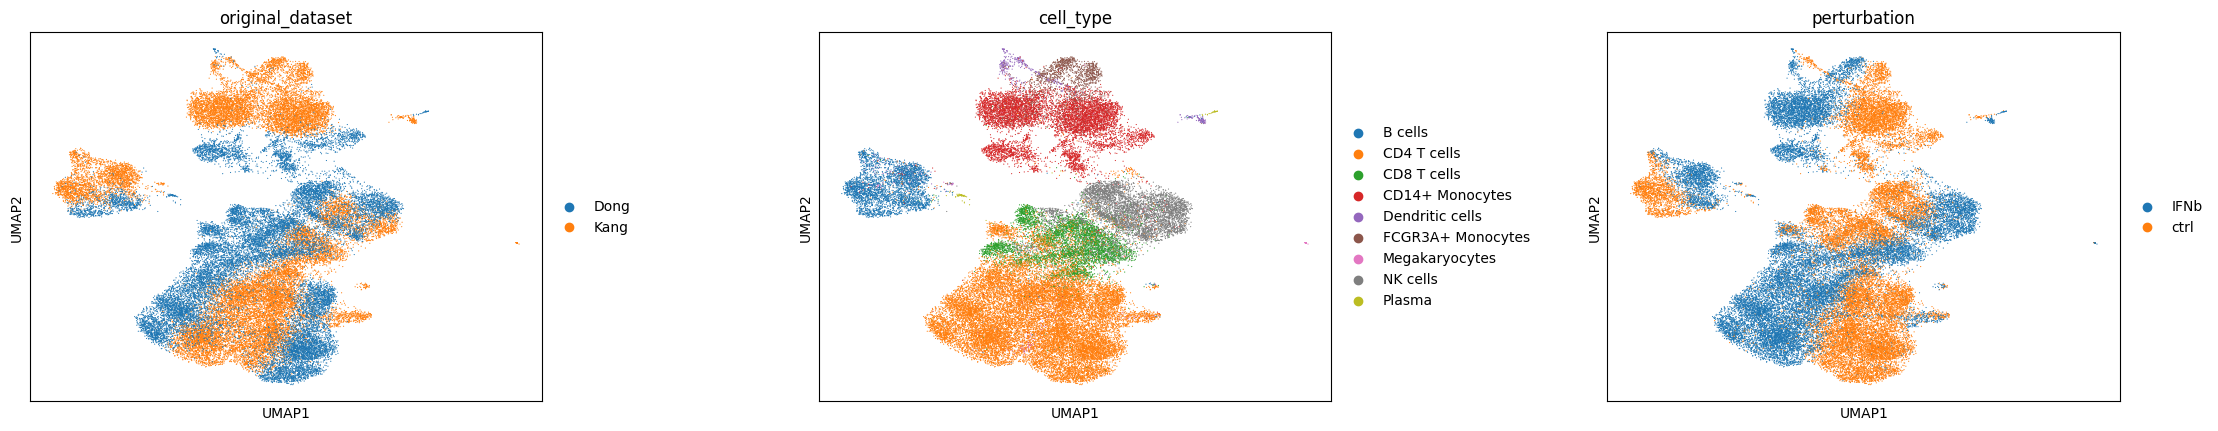

In [8]:
# UMAP provided by dataset
sc.pl.umap(adata, color=['original_dataset','cell_type', 'perturbation'], wspace=0.4)

In [9]:
adata.obs.head(10)  # viewing the first 10 rows of the observation metadata (cell-level)

,perturbation,batch,cell_type,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,_scvi_batch,_scvi_labels,leiden,original_dataset
AAACATACATTTCC-1,ctrl,Kang_ctrl,CD14+ Monocytes,878,3018.0,0.0,0.0,0,0,4,Kang
AAACATACCAGAAA-1,ctrl,Kang_ctrl,CD14+ Monocytes,713,2481.0,0.0,0.0,0,0,4,Kang
AAACATACCATGCA-1,ctrl,Kang_ctrl,CD4 T cells,337,703.0,0.0,0.0,0,0,10,Kang
AAACATACCTCGCT-1,ctrl,Kang_ctrl,CD14+ Monocytes,850,3420.0,0.0,0.0,0,0,4,Kang
AAACATACCTGGTA-1,ctrl,Kang_ctrl,Dendritic cells,1111,3158.0,0.0,0.0,0,0,12,Kang
AAACATACGATGAA-1,ctrl,Kang_ctrl,CD4 T cells,635,1869.0,0.0,0.0,0,0,3,Kang
AAACATACGCCAAT-1,ctrl,Kang_ctrl,CD14+ Monocytes,436,1142.0,0.0,0.0,0,0,4,Kang
AAACATACGCTTCC-1,ctrl,Kang_ctrl,CD4 T cells,427,817.0,0.0,0.0,0,0,0,Kang
AAACATACGGCATT-1,ctrl,Kang_ctrl,CD14+ Monocytes,558,1582.0,0.0,0.0,0,0,4,Kang
AAACATACGTGTAC-1,ctrl,Kang_ctrl,NK cells,474,728.0,0.0,0.0,0,0,2,Kang


In [10]:
# 1) Subset only CD4 T cells from the integrated AnnData
cd4 = adata[adata.obs['cell_type'] == 'CD4 T cells'].copy()

In [11]:
cd4

AnnData object with n_obs × n_vars = 20684 × 3000
    obs: 'perturbation', 'batch', 'cell_type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', '_scvi_batch', '_scvi_labels', 'leiden', 'original_dataset'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'batch_colors', 'cell_type_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'perturbation_colors', 'umap', 'original_dataset_colors'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'counts', 'scvi_normalized'
    obsp: 'connectivities', 'distances'

perturbation
ctrl    10619
IFNb    10065
Name: count, dtype: int64

original_dataset
Kang    24471
Dong    19863
Name: count, dtype: int64

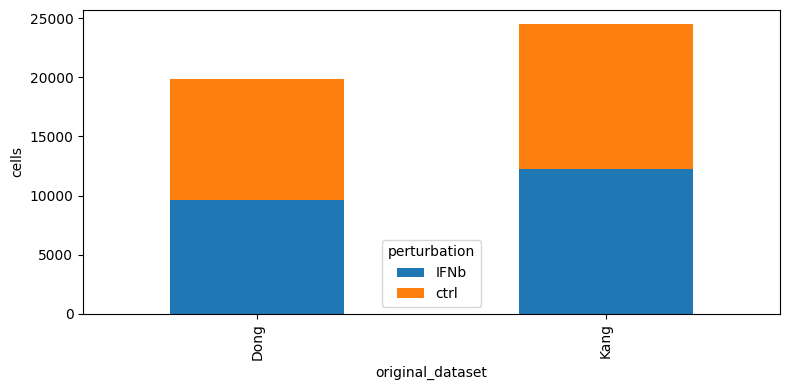

In [12]:
display(cd4.obs['perturbation'].value_counts())  # counting the number of cells in each condition

display(adata.obs['original_dataset'].value_counts())  # counting the number of cells in each cell type

# Bar plot: cells per type × condition
count_df = (adata.obs.groupby(['original_dataset','perturbation'], observed=True)['perturbation']
            .count().unstack().fillna(0))
count_df.plot.bar(stacked=True, figsize=(8,4))
plt.ylabel('cells'); plt.tight_layout(); plt.show()

Training Epoch 9: 100%|██████████| 10/10 [00:43<00:00,  4.36s/it, SCPRAM_loss=102, kl_loss=575, recon_loss=203]


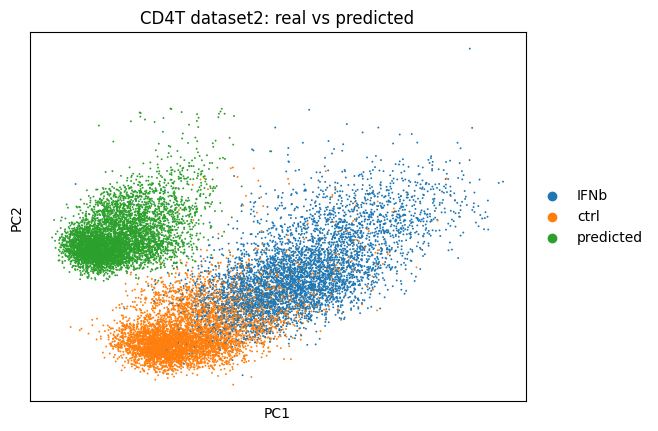

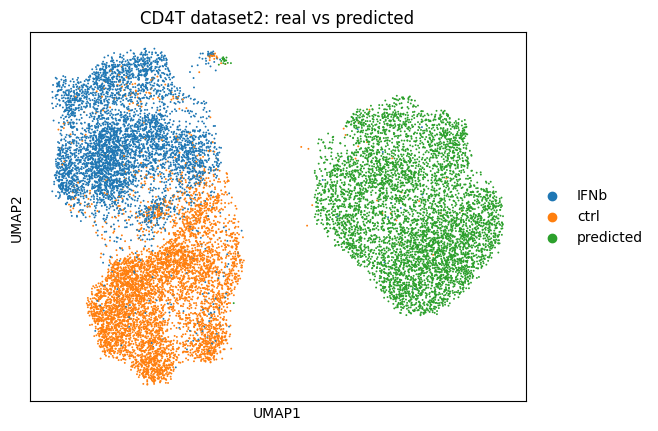

In [13]:
# 2) Treat “dataset” as the cell-type key so we can hold out exactly dataset2 stim
key_dic_dataset = {
    'condition_key': 'perturbation',
    'cell_type_key': 'original_dataset',
    'ctrl_key'     : 'ctrl',
    'stim_key'     : 'IFNb',
    'pred_key'     : 'predicted'
}

# 3) Hold out only dataset2-stim CD4T cells
train = cd4[~(
    (cd4.obs['original_dataset']   == 'Dong') &
    (cd4.obs['perturbation'] == 'IFNb')
)].copy()



# 4) Train scPRAM
model = models.SCPRAM(input_dim=adata.n_vars, device='cpu')#or 'cuda'
model = model.to(model.device)
model.train_SCPRAM(train, epochs=10, batch_size=128, lr=5e-5)

# 5) Predict held-out dataset2 CD4T-stim cells
pred = model.predict(
    train_adata  = train,
    cell_to_pred = 'Dong',
    key_dic      = key_dic_dataset,
    ratio        = 0.005
)


# 6) Build evaluation AnnData exactly like in the static section


ground_truth = cd4[(cd4.obs['original_dataset'] == 'Dong')]

eval_ad = ground_truth.concatenate(pred)
eval_ad.obs['perturbation'] = (
    eval_ad.obs['perturbation']
    .astype('category')
    .cat.remove_unused_categories()
)

# 7) Run PCA/UMAP & visualize
sc.tl.pca(eval_ad, n_comps=30, svd_solver='arpack')
sc.pp.neighbors(eval_ad)
sc.tl.umap(eval_ad)
sc.pl.pca(eval_ad, color='perturbation', title='CD4T dataset2: real vs predicted')
sc.pl.umap(eval_ad, color='perturbation', title='CD4T dataset2: real vs predicted')

Font 'default' does not have a glyph for '\u2002' [U+2002], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2002' [U+2002], substituting with a dummy symbol.


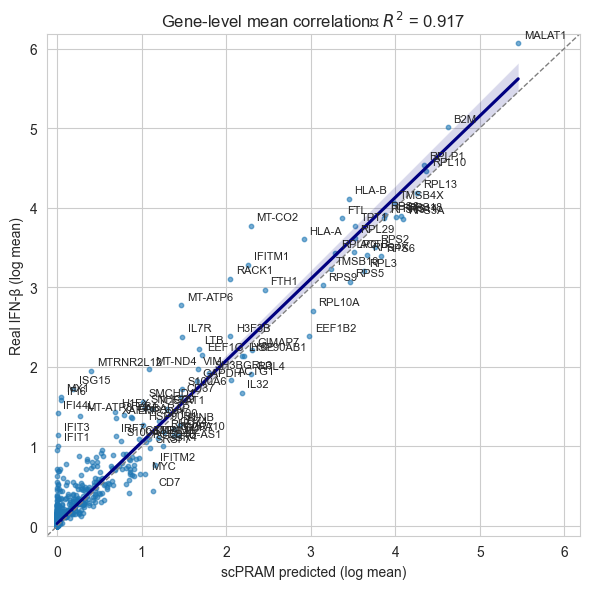

In [14]:
# 8) Compute metrics as before
X = eval_ad.X.A if issparse(eval_ad.X) else eval_ad.X
stim_m = eval_ad.obs['perturbation'] == 'IFNb'
pred_m = eval_ad.obs['perturbation'] == 'predicted'

# 
# ── 1) per-gene means and R² ─────────────────────────────────────────────
stim_means = X[stim_m].mean(axis=0)        # ground-truth
pred_means = X[pred_m].mean(axis=0)        # scGen estimate
r2 = r2_score(stim_means, pred_means)

# wrap into a DataFrame so we can use seaborn + gene names
df = pd.DataFrame(
    {"pred": pred_means,
     "real": stim_means},
    index = eval_ad.var_names            # gene names as index
)

# ── 2) basic scatter with regression ribbon ──────────────────────────────
sns.set_style("whitegrid")               # light grid
plt.figure(figsize=(6,6))

ax = sns.regplot(
    data       = df,
    x          = "pred",
    y          = "real",
    scatter_kws= dict(s=10, alpha=0.6),
    line_kws   = dict(color="navy"),
    ci         = 95                      # 95 % conf. band
)

# reference diagonal
data_min = min(df.min())
data_max = max(df.max())
pad      = 0.02 * (data_max - data_min)      # 2 % of the data range
lims     = [data_min - pad, data_max + pad]

ax.set_xlim(lims)
ax.set_ylim(lims)
ax.plot(lims, lims, "--", color="grey", linewidth=1)

# ── 3) annotate “interesting” genes (> 1 log-mean in either set) ─────────
mask = (df["pred"] > 1) | (df["real"] > 1)
for gene, row in df[mask].iterrows():
    ax.annotate(gene,
                (row["pred"], row["real"]),
                xytext=(4,4),
                textcoords="offset points",
                fontsize=8)

# axes & title
ax.set_xlim(lims); ax.set_ylim(lims)
ax.set_xlabel("scPRAM predicted (log mean)")
ax.set_ylabel("Real IFN-β (log mean)")
ax.set_title(f"Gene-level mean correlation  $R^2$ = {r2:.3f}")

plt.tight_layout()
plt.show()

,R2,MSE,Pearson,Edist,MV_KDE,Jaccard
original_dataset,,,,,,
Dong_CD4 T cells,0.916,0.016,0.961,6.046,0.031,0.130


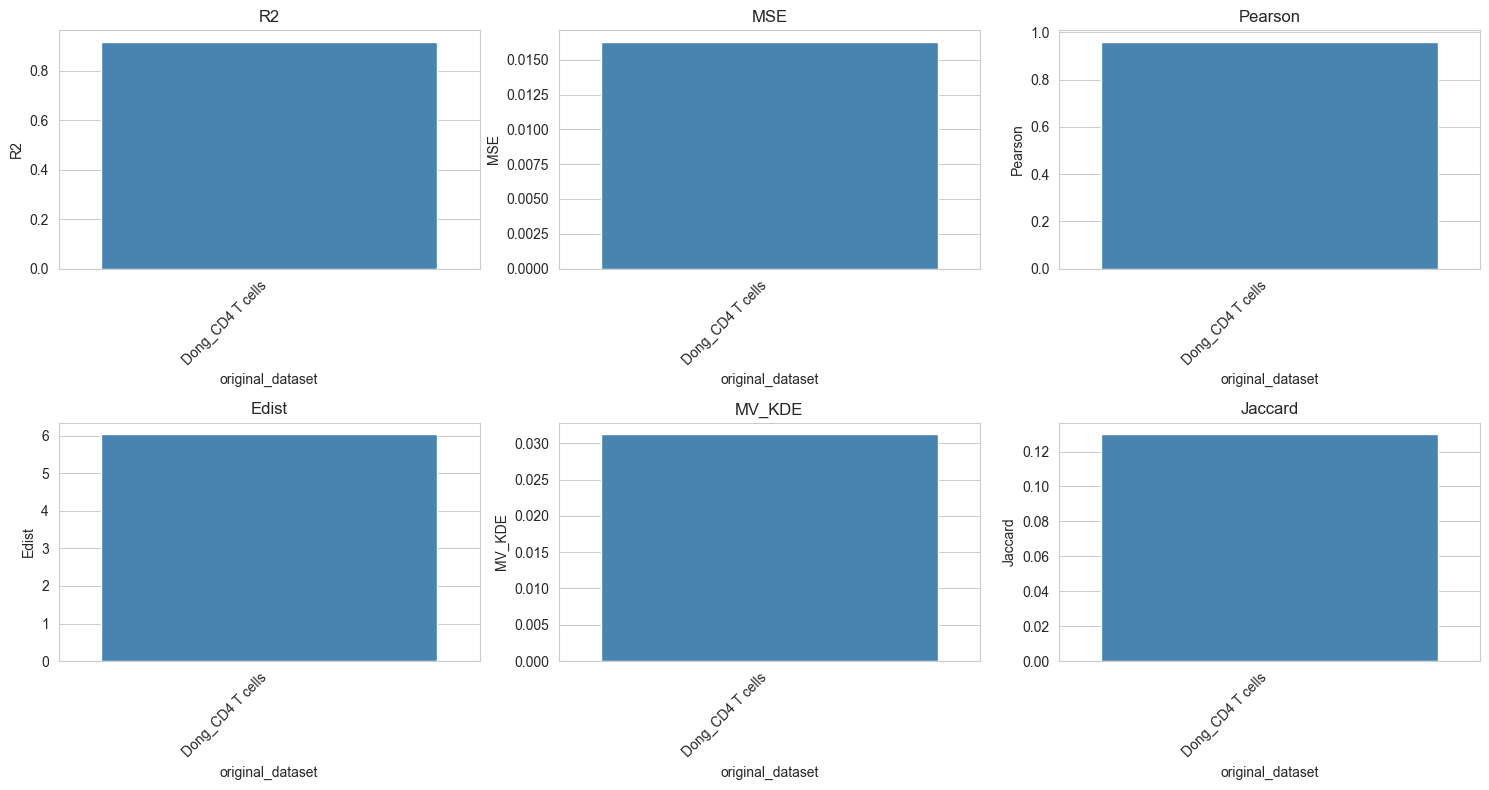

In [15]:
# Corrected Metrics & Plot Block
results = []
# Ensure PCA is computed on eval_ad and update pca_coords
sc.tl.pca(eval_ad, n_comps=30, svd_solver="arpack")
pca_coords = eval_ad.obsm['X_pca']

# Masks for stimulated vs. predicted
cond     = eval_ad.obs[key_dic_dataset['condition_key']]
stim_m   = cond == key_dic_dataset['stim_key']
pred_m   = cond == key_dic_dataset['pred_key']

# Dense matrix if sparse
X = eval_ad.X.A if issparse(eval_ad.X) else eval_ad.X

# 1) Bootstrapped metrics
boot = bootstrap_metrics(
    X,
    stim_m.values,
    pred_m.values,
    pca_coords,       # freshly computed above
    n_boot=100,
    frac=0.8,
    seed=SEED
)

# 2) Mean-variance KDE
mv_kde = mean_var_kde_distance(X[stim_m.values], X[pred_m.values])

# 3) Jaccard top100 DEGs
sc.tl.rank_genes_groups(
    eval_ad,
    groupby   = key_dic_dataset['condition_key'],
    reference = key_dic_dataset['ctrl_key'],
    groups    = [key_dic_dataset['stim_key'], key_dic_dataset['pred_key']],
    method    = "wilcoxon",
    n_genes   = eval_ad.n_vars
)
true_top = eval_ad.uns['rank_genes_groups']['names'][key_dic_dataset['stim_key']][:100]
pred_top = eval_ad.uns['rank_genes_groups']['names'][key_dic_dataset['pred_key']][:100]
shared   = set(true_top) & set(pred_top)
jaccard  = len(shared) / (len(true_top) + len(pred_top) - len(shared))

# 4) Collect results
results.append({
    "original_dataset": 'Dong_CD4 T cells',
    "R2":       boot["R2_mean"],
    "MSE":      boot["MSE_mean"],
    "Pearson":  boot["Pearson_mean"],
    "Edist":    boot["Edist_mean"],
    "MV_KDE":   mv_kde,
    "Jaccard":  jaccard
})

# 5) Build DataFrame & display
df = pd.DataFrame(results).set_index("original_dataset")
display(df.style.format("{:.3f}"))

# 6) Bar-plots with Seaborn Blues_d
import seaborn as sns
import matplotlib.pyplot as plt

metrics = df.columns.tolist()
cols   = 3
rows   = (len(metrics) + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows), squeeze=False)
axes = axes.flatten()

for ax, m in zip(axes, metrics):
    sns.barplot(x=df.index, y=df[m], ax=ax, palette="Blues_d")
    ax.set_title(m)
    ax.set_ylabel(m)
    ax.set_xticklabels(df.index, rotation=45, ha='right')

for ax in axes[len(metrics):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

## Let's play with an object without batch correction

In [18]:
# Load dataset
adata = sc.read_h5ad('/home/sabrina/Documents/Perturb-Bench2/files/unintegrated_Kang_Dong.h5ad')  # replace with your file
adata

AnnData object with n_obs × n_vars = 44334 × 42240
    obs: 'perturbation', 'batch', 'cell_type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'

In [21]:
# Preprocessing: QC, log-normalisation, HVG selection
#sc.pp.filter_cells(adata, min_counts=1000)
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
#sc.pp.scale(adata, max_value=10, zero_center=False)
sc.pp.highly_variable_genes(adata, n_top_genes=3000, subset=True, flavor='seurat')

In [23]:
adata.obs['original_dataset'] = np.where(
    adata.obs['batch'].isin(['Kang_ctrl', 'Kang_stim']),
    'Kang',
    'Dong'
)

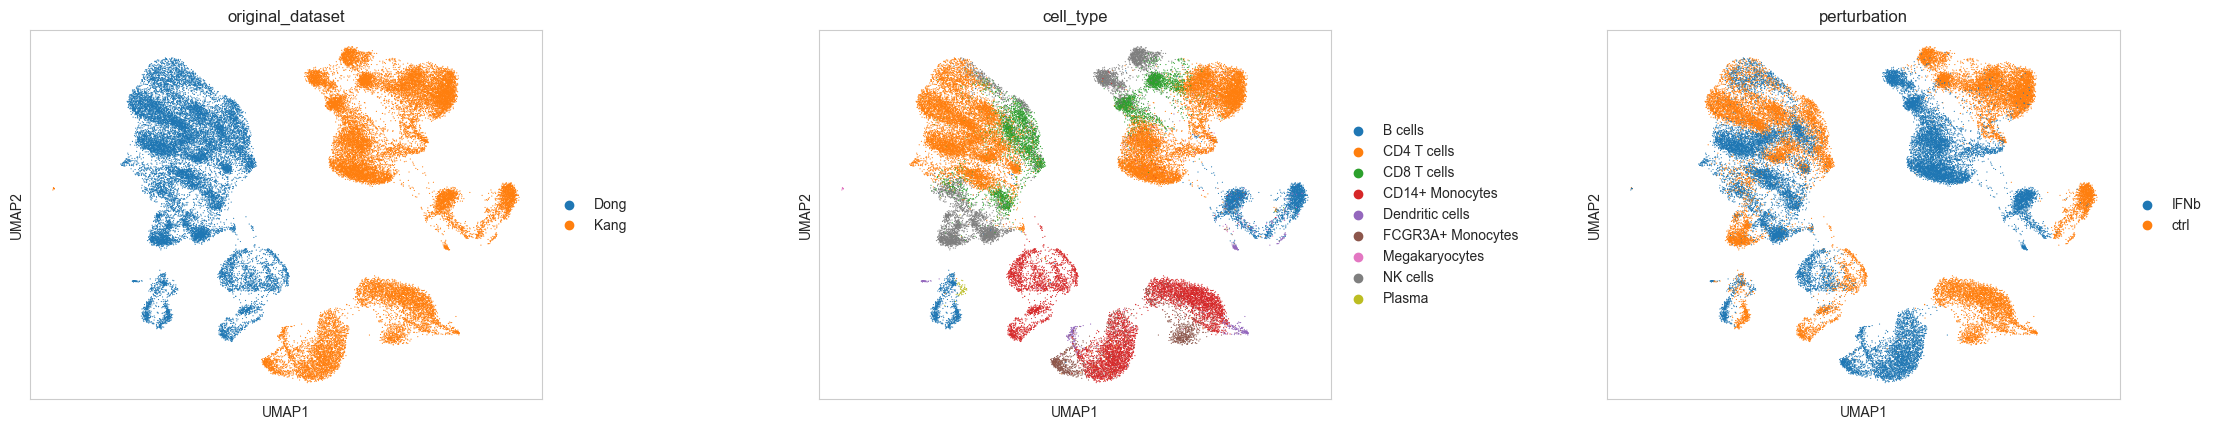

In [24]:
# UMAP provided by dataset
sc.pl.umap(adata, color=['original_dataset','cell_type', 'perturbation'], wspace=0.4)

In [25]:
# 1) Subset only CD4 T cells from the integrated AnnData
cd4 = adata[adata.obs['cell_type'] == 'CD4 T cells'].copy()

Training Epoch 9: 100%|██████████| 10/10 [00:04<00:00,  2.21it/s, SCPRAM_loss=97.8, kl_loss=799, recon_loss=195]


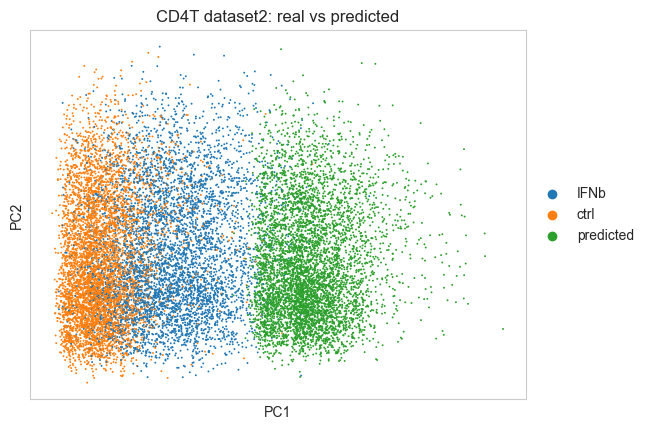

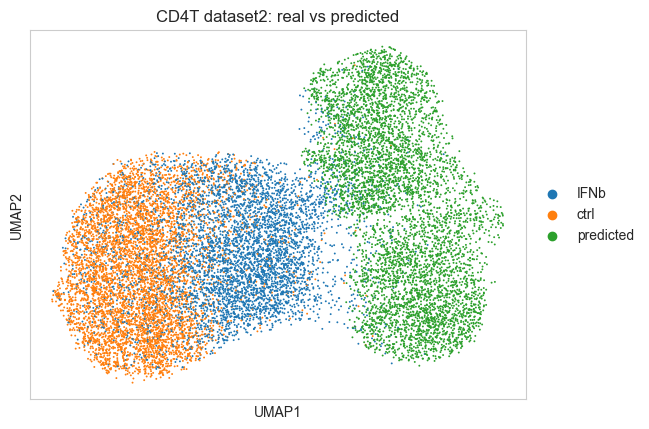

In [ ]:
# 2) Treat “dataset” as the cell-type key so we can hold out exactly dataset2 stim
key_dic_dataset = {
    'condition_key': 'perturbation',
    'cell_type_key': 'original_dataset',
    'ctrl_key'     : 'ctrl',
    'stim_key'     : 'IFNb',
    'pred_key'     : 'predicted'
}

# 3) Hold out only dataset2-stim CD4T cells
train = cd4[~(
    (cd4.obs['original_dataset']   == 'Dong') &
    (cd4.obs['perturbation'] == 'IFNb')
)].copy()



# 4) Train scPRAM
model = models.SCPRAM(input_dim=adata.n_vars, device='cpu')#'cuda'
model = model.to(model.device)
model.train_SCPRAM(train, epochs=10, batch_size=128, lr=5e-5)

# 5) Predict held-out dataset2 CD4T-stim cells
pred = model.predict(
    train_adata  = train,
    cell_to_pred = 'Dong',
    key_dic      = key_dic_dataset,
    ratio        = 0.005
)


# 6) Build evaluation AnnData exactly like in the static section


ground_truth = cd4[(cd4.obs['original_dataset'] == 'Dong')]

eval_ad = ground_truth.concatenate(pred)
eval_ad.obs['perturbation'] = (
    eval_ad.obs['perturbation']
    .astype('category')
    .cat.remove_unused_categories()
)

# 7) Run PCA/UMAP & visualize
sc.tl.pca(eval_ad, n_comps=30, svd_solver='arpack')
sc.pp.neighbors(eval_ad)
sc.tl.umap(eval_ad)
sc.pl.pca(eval_ad, color='perturbation', title='CD4T dataset2: real vs predicted')
sc.pl.umap(eval_ad, color='perturbation', title='CD4T dataset2: real vs predicted')

,R2,MSE,Pearson,Edist,MV_KDE,Jaccard
original_dataset,,,,,,
cinemaot_CD4 T cells,0.618,0.007,0.905,3.523,0.003,0.266


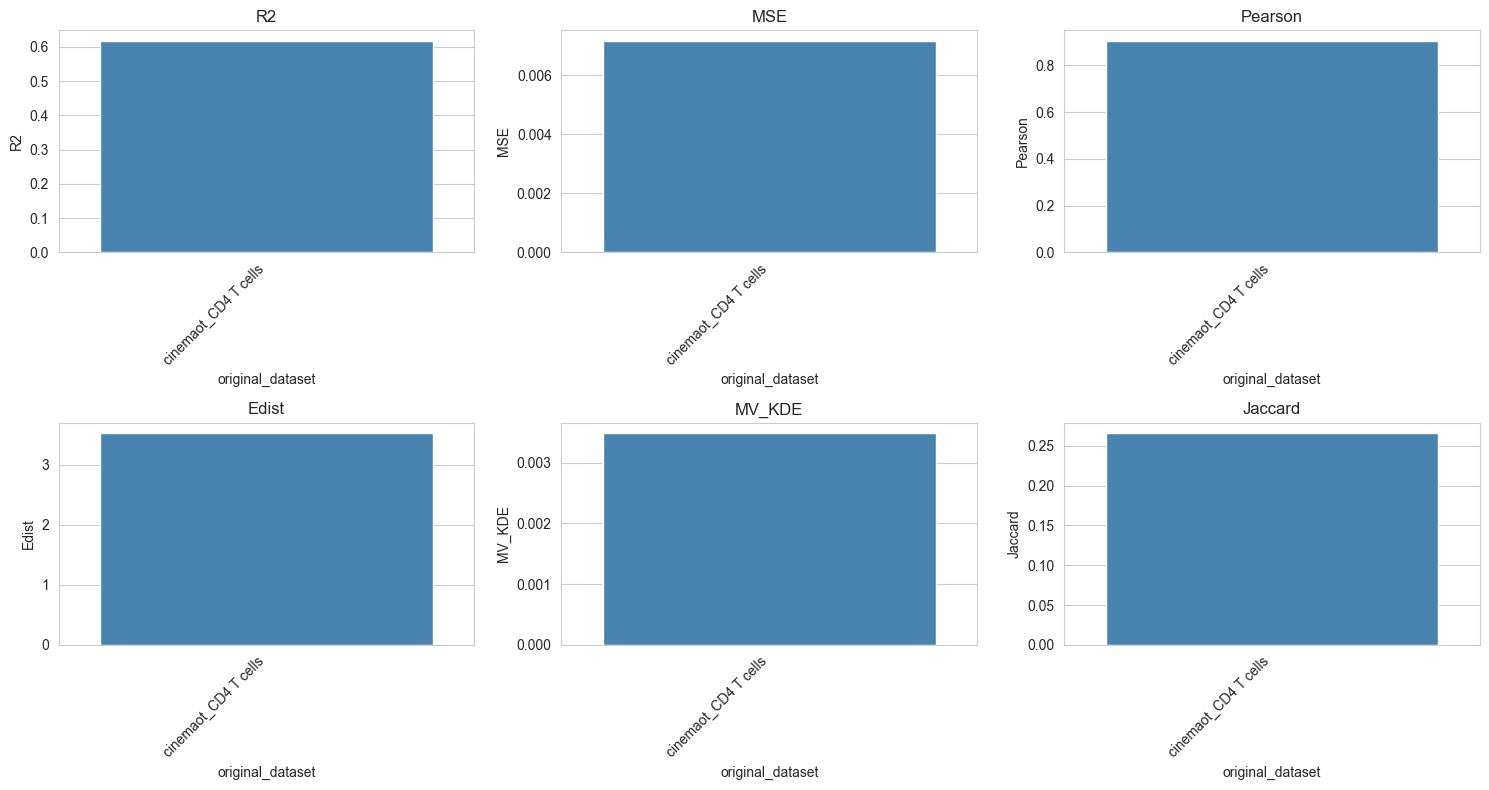

In [29]:
# Corrected Metrics & Plot Block
results = []
# Ensure PCA is computed on eval_ad and update pca_coords
sc.tl.pca(eval_ad, n_comps=30, svd_solver="arpack")
pca_coords = eval_ad.obsm['X_pca']

# Masks for stimulated vs. predicted
cond     = eval_ad.obs[key_dic_dataset['condition_key']]
stim_m   = cond == key_dic_dataset['stim_key']
pred_m   = cond == key_dic_dataset['pred_key']

# Dense matrix if sparse
X = eval_ad.X.A if issparse(eval_ad.X) else eval_ad.X

# 1) Bootstrapped metrics
boot = bootstrap_metrics(
    X,
    stim_m.values,
    pred_m.values,
    pca_coords,       # freshly computed above
    n_boot=100,
    frac=0.8,
    seed=SEED
)

# 2) Mean-variance KDE
mv_kde = mean_var_kde_distance(X[stim_m.values], X[pred_m.values])

# 3) Jaccard top100 DEGs
sc.tl.rank_genes_groups(
    eval_ad,
    groupby   = key_dic_dataset['condition_key'],
    reference = key_dic_dataset['ctrl_key'],
    groups    = [key_dic_dataset['stim_key'], key_dic_dataset['pred_key']],
    method    = "wilcoxon",
    n_genes   = eval_ad.n_vars
)
true_top = eval_ad.uns['rank_genes_groups']['names'][key_dic_dataset['stim_key']][:100]
pred_top = eval_ad.uns['rank_genes_groups']['names'][key_dic_dataset['pred_key']][:100]
shared   = set(true_top) & set(pred_top)
jaccard  = len(shared) / (len(true_top) + len(pred_top) - len(shared))

# 4) Collect results
results.append({
    "original_dataset": 'cinemaot_CD4 T cells',
    "R2":       boot["R2_mean"],
    "MSE":      boot["MSE_mean"],
    "Pearson":  boot["Pearson_mean"],
    "Edist":    boot["Edist_mean"],
    "MV_KDE":   mv_kde,
    "Jaccard":  jaccard
})

# 5) Build DataFrame & display
df = pd.DataFrame(results).set_index("original_dataset")
display(df.style.format("{:.3f}"))

# 6) Bar-plots with Seaborn Blues_d
import seaborn as sns
import matplotlib.pyplot as plt

metrics = df.columns.tolist()
cols   = 3
rows   = (len(metrics) + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows), squeeze=False)
axes = axes.flatten()

for ax, m in zip(axes, metrics):
    sns.barplot(x=df.index, y=df[m], ax=ax, palette="Blues_d")
    ax.set_title(m)
    ax.set_ylabel(m)
    ax.set_xticklabels(df.index, rotation=45, ha='right')

for ax in axes[len(metrics):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

## Conclusion

- **Attention-driven perturbation**  
  scPRAM’s key innovation is its per-cell attention mechanism, which adapts each predicted profile to the most relevant control neighbors, capturing single-cell heterogeneity more faithfully than global shifts.

- **Robust within-dataset performance**  
  Across multiple cell types and perturbations, scPRAM achieves high R² and low energy-distance metrics, outperforming earlier VAE-based methods (scGen, trVAE) in reconstructing true stimulated profiles.

- **Transparent cross-study transfer**  
  While the original paper glosses over cross-dataset extrapolation, our workflow demonstrates that with careful integration and cell-type-specific training, scPRAM can predict perturbations in a new cohort—providing a reproducible protocol missing from the literature.

- **Cell-type focus**  
  Prediction accuracy varies widely by lineage; isolating one cell type at a time aligns with biologists’ practical needs and scPRAM’s single-axis design, avoiding the complexity of multifactor modeling.

- **Integration & evaluation pipeline**  
  Successful extrapolation depends on robust batch-correction (Harmony, MNN, Seurat CCA, etc.), followed by rigorous benchmarking (R², MSE, energy/KDE distances, DEG overlap, attention heatmaps) to validate transfer fidelity.

- **Future directions**  
  Extending scPRAM toward multi-perturbation or hierarchical attention, incorporating additional biological covariates, and automating integration selection will further empower cross-study single-cell perturbation analysis.
